First run shared code all cells in section 'Shared code'.  
The following sections 2 to 5 can be run independently, but inside each section, cell order should be observed.  
Where noted, additional data that is produced by the Simulation notebook needs to be prepared.

# Shared code

In [1]:
# base path for input files
INPUTBASE = './'

Plotting setup:  
Figures in paper use mathcal which is not supported by matplotlib out of the box and requires latex backend.

Run one of the cells below to use labels without or with latex backend.

In [2]:
latex = False

def fmt_title(name, i, post="", pre=""):
    if i % 2 == 0:
        return f"{pre} ${name}_{i//2+1}$ {post}"
    else:
        return f"{pre} ${name}_{i//2+1}'$ {post}"

In [3]:
latex = True

# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = (''
    #+ r'\usepackage{siunitx}'   # i need upright \micro symbols, but you need...
    #+ r'\sisetup{detect-all}'   # ...this to force siunitx to actually use your fonts
    #+ r'\usepackage{helvet}'    # set the normal font here
    + r'\usepackage{amstext}'   # \text{} in math mode
    + r'\usepackage{sansmath}'  # load up the sansmath so that math -> helvet
    + r'\sansmath'              # <- tricky! -- gotta actually tell tex to use!
)

def fmt_title(name, i, post="", pre=""):
    if i % 2 == 0:
        return f"{pre} ${name}_{i//2+1}$ {post}"
    else:
        return f"{pre} $\\mathcal{{{name}}}_{i//2+1}$ {post}"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook


def rainbow(n, i, shift=0):
    if n == 1: return plt.cm.nipy_spectral(0)
    x = i / (n-1) + shift
    return plt.cm.nipy_spectral(0.96 * (x % 1.01))


METALEN = 6
INIT_SAMPLE = 200
CLIPPING_WARNING = 15


# Load data from running u1drive1.c on a chain of Red Pitayas
# using the run-chain.sh bash script, which concatenates
# outputs into one file.
#
# Metadata in the beginning of the second axis:
# 0 samplerate,
# 1 driving freq,
# 2 driving amplitude,
# 3 driving phase,
# 4 ttlCH2 delay,
# 5 channel,
# 6... samples
#
# Returns array of shape (channels, shots, meta+samples)
def load_chain(inputfile):
    # Route through pandas to support gzipped files
    data = pd.read_csv(INPUTBASE+inputfile, delimiter='\t', header=None).values
    assert np.all(data[:,0] == data[0,0]), "Not all at same samplerate in "+inputfile
    assert np.all(np.absolute(data[:, METALEN:]) < CLIPPING_WARNING), "Maybe clipping values in "+inputfile
    
    chnum = int(np.max(data[:,5]))
    shots = data.shape[0] // chnum
    assert data.shape[0] == chnum * shots
    
    # Splice rows to order data: each RP has two fast ADC channels,
    # and their outputs are appended.
    # (all rows of the same shot next to each other)
    # 1, 2, 1, 2, ..., 3, 4, 3, 4, ...  =>  1, 2, 3, 4, 1, 2, 3, 4, ....
    sorted = np.zeros((chnum, shots, data.shape[1]))
    for i in range(shots):
        for rpidx in range(chnum//2):
            assert data[shots*rpidx*2+i*2  ,5] - rpidx*2 == 1
            assert data[shots*rpidx*2+i*2+1,5] - rpidx*2 == 2
            sorted[rpidx*2  ,i] = data[shots*rpidx*2+i*2]
            sorted[rpidx*2+1,i] = data[shots*rpidx*2+i*2+1]
    
    return sorted


# Combine multiple data sets loaded with load_chain() into one array,
# because multiple runs are required to see the whole chain.
#
# Does not reset channel indexing in metadata.
#
# datas: list of arrays as returned by load_chain()
# idxs: list of 2-tuples with idx in datas and one channel idx (starting from 0)
def mux_lattice(datas, idxs):
    shots = datas[0].shape[1]
    assert all(d.shape[1] == shots for d in datas), \
        "Number of measurements doesn't match for all data sets."
    
    lattice = np.zeros((len(idxs), shots, datas[0].shape[2]))
    for i, (dataidx, chidx) in enumerate(idxs):
        lattice[i] = datas[dataidx][chidx]
    return lattice


def plot_traces(data, idx=0):
    """Plot time traces."""
    samplerate = data[0,idx,0]
    print("samplerate {}, frequency {} Hz,\namplitude {} V, phase {} rad,\nch2 delay {} s".format(*data[0,idx,:METALEN-1]))
    ts = (np.arange(data.shape[-1]-METALEN)-INIT_SAMPLE) / samplerate
    
    fig, axs = plt.subplots(nrows=data.shape[0], figsize=(10,13), sharex=True)
    for ch in range(data.shape[0]):
        axs[ch].plot(ts*1e3, data[ch, idx, METALEN:], color=('C0' if ch%2==0 else 'C1'))
        axs[ch].set_ylabel(f"CH{ch+1}")
        axs[ch].grid()
    axs[-1].set_xlabel('time / ms')
    fig.tight_layout()
    
    return fig, axs

In [5]:
def calcδ(fs):
    """Detuning for each link."""
    fsites = fs[::2]
    flinks = fs[1::2]
    return np.array([
        flinks[i] - (-1)**(i+1) * (fsites[i] - fsites[i+1]) for i in range(len(flinks))])

def calcΔ(δ):
    """Mass at each site."""
    Δ = np.zeros(len(δ)+1)
    Δ[0] = δ[0]
    for i in range(1, Δ.shape[0]):
        Δ[i] = 2 * δ[i-1] - Δ[i-1]
    return Δ

def calcΩ(fs, f0=60e3, V0=1, Vref=10):
    fsites = fs[::2]
    flinks = fs[1::2]
    return np.array([
        np.sqrt(fsites[i]*flinks[i]*fsites[i+1] / (2 * f0**3)) / 4 * V0/Vref
        for i in range(len(flinks))])

def calc_rfbase(fs):
    "Zero frequencies of rotating frame in non-rotating frame."
    Δ = calcΔ(calcδ(fs))
    return np.array([
        fs[i] + (-1)**(i//2+1) * Δ[i//2]/2 if i%2 == 0 else fs[i]
              for i in range(len(fs))])

In [6]:
from numpy.fft import fft, fftfreq, fftshift, rfft, rfftfreq
from scipy.signal import windows

from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator


HANN_PEAKLOSS = 10**(-6.02/20)
BOXCAR_PEAKLOSS = 1
FLATTOP_PEAKLOSS = 10**(-13.3/20)


def time_spectrum(signal, samplerate, window):
    """Calculate voltage amplitude spectrum [V] along last axis.
    Normalization is chosen such that the resulting absolute value V
    in the spectrum some is directly connected to prefactors in
    harmonic series A cos(2pi f t) + B sin(2pi f t) like
    V = sqrt(A**2 + B**2).
    """
    n = signal.shape[-1]
    spectrum = np.absolute(rfft(signal * window(n), axis=-1) / n * 2)
    fbins = rfftfreq(n, 1/samplerate)
    return spectrum, fbins


def shift_to_rotating_frame(spectrum, fbins, fs, fwidth):
    """Shift spectra to rotating frame with same bins.
    Does not resample, so precision is limited by bin size.
    
    Arguments:
    spectrum: data with lattice along first axis and
        spectrum data along last axis.
    fbins: frequency bins
    fs: free resonance frequencies
    fwidth: frequency width of spectrum in rotating frame
    
    Returns:
    rfspectrum: shifted and cut spectrum
    rfbins: bins for the shifted spectrum (along last axis)
    rf: reference frequencies of rotating frame
    """
    rf = calc_rfbase(fs)
    
    fstep = fbins[1] - fbins[0]
    rfbins = np.arange(fwidth/fstep) * fstep - round(fwidth/2/fstep)*fstep
    
    idxlo = np.argmin(np.absolute(fbins[:,np.newaxis] - rf[np.newaxis,:] + fwidth/2), axis=0)
    idxhi = np.argmin(np.absolute(fbins[:,np.newaxis] - rf[np.newaxis,:] - fwidth/2), axis=0)
    rfspectrum = np.full(spectrum.shape[:-1]+(len(rfbins),), np.nan, dtype=spectrum.dtype)
    for i, (lo, hi) in enumerate(zip(idxlo, idxhi)):
        align = np.argmin(np.absolute(rfbins - fbins[lo] + rf[i]))
        rfspectrum[i,...,align:align+hi-lo] = spectrum[i,...,lo:hi]
    
    return rfspectrum, rfbins, rf


def plot_spectrum(spectrum, fbins, xs, fs=None, frange=None, vmin=1e-5, vmax=1e0, cmap='viridis', xlabel="f drv / kHz"):
    LWIDTH = 1
    n = spectrum.shape[0]
    fig, axs = plt.subplots(
        ncols=n, figsize=(13, 5),
        sharex=True, sharey=frange is None,constrained_layout=True)
    for i in range(n):
        im = axs[i].imshow(
            spectrum[i,:,:].T, origin='lower',
            extent=(xs[0], xs[-1], fbins[0]/1e3, fbins[-1]/1e3),
            norm=LogNorm(vmin=vmin, vmax=vmax),
            cmap=cmap, aspect='auto')
        axs[i].set_title(fmt_title("V", i))

        if fs is not None:
            axs[i].axhline(fs[i]/1e3, color='C1', linewidth=LWIDTH)
            if i%2 == 0:
                if i-4 >= 0:
                    axs[i].axhline(fs[i-4]/1e3, color='C1', linestyle='--', linewidth=LWIDTH)
                if i+4 < n:
                    axs[i].axhline(fs[i+4]/1e3, color='C1', linestyle='-.', linewidth=LWIDTH)
            else:
                if i-2 > 0:
                    axs[i].axhline(fs[i-2]/1e3, color='C1', linestyle='--', linewidth=LWIDTH)
                if i+2 < n:
                    axs[i].axhline(fs[i+2]/1e3, color='C1', linestyle='-.', linewidth=LWIDTH)
            if frange is not None:
                axs[i].set_ylim((fs[i]-frange)/1e3, (fs[i]+frange)/1e3)
    
    axs[0].set_ylabel("f / kHz")
    axs[len(axs)//2].set_xlabel(xlabel)
    fig.colorbar(im, ax=axs).set_label('Voltage amplitude / V')
    return fig, axs


lwidth = 1
PTcolor = 'black'
PTSTY = '--' # (0, (5, 5))

DRVcolor = 'maroon'
DRVLSTY = (0, (3, 5, 1, 5))

Δcolor = 'lime'
ΔSTY = (0, (3, 5, 1, 5))

# ffts: (2l+1 sites, i x-axis variable, m fourier bins)
# fftbins: m fourier bins in absolute values [Hz]
# fs: free resonance frequencies [Hz]
# xs, xlabel: x axis [arbitrary units]
# fdrv: driving frequencies in rot. frame [Hz], assuming xs = fdrv/1e3
# fdrvcorr: data picking correction relative to fdrv
# frange: y axis plus/minus range
# vmin, vmax: color scale min/max
def plot_rotating_frame(
        ffts, fftbins, fs, xs, xlabel,
        fdrv=None, idxs=None, frange=10e3, vmin=3e-7, vmax=3e-3,
        freelines=True, subplots_kw={}):
    Δs = calcΔ(calcδ(fs)) # Hz
    print("Δ", Δs/1e3, "kHz")
    m = np.mean(Δs)/2
    print("m average", m/1e3, "kHz")
    rfs = calc_rfbase(fs)
    
    if idxs is None:
        idxs = list(range(ffts.shape[0]))
    fig, axs = plt.subplots(ncols=len(idxs), figsize=(11, 5),
                            sharex=True, sharey=True, constrained_layout=True,
                            **subplots_kw)
    for i, idx in enumerate(idxs):
        if freelines and idx % 2 == 0: # site
            if idx//2 % 2 == 0: # odd site
                axs[i].axhline(m/1e3, linestyle='-', color=PTcolor, linewidth=lwidth)
                axs[i].axhline(-m/1e3, linestyle=PTSTY, color=PTcolor, linewidth=lwidth)
            else:
                axs[i].axhline(m/1e3, linestyle=PTSTY, color=PTcolor, linewidth=lwidth)
                axs[i].axhline(-m/1e3, linestyle='-', color=PTcolor, linewidth=lwidth)
            if fdrv is not None:
                axs[i].plot(xs, fdrv/1e3, linestyle=DRVLSTY, color=DRVcolor, linewidth=lwidth)
        elif freelines:
            axs[i].axhline(0, linestyle='-', color=PTcolor, linewidth=lwidth)
            axs[i].axhline(-2*m/1e3, linestyle=PTSTY, color=PTcolor, linewidth=lwidth)
        
        cmap = 'Purples' if i%2 == 0 else 'Oranges'
        df = fftbins[1]
        im = axs[i].imshow(
            ffts[idx].T, origin='lower',
            extent=(
                xs[0], xs[-1],
                (fftbins[0]-rfs[idx]-df/2)/1e3,
                (fftbins[-1]-rfs[idx]+df/2)/1e3),
            norm=LogNorm(vmin=vmin, vmax=vmax),
            cmap=cmap, aspect='auto')
        if i%2 == 0:
            im1 = im
        else:
            im2 = im
        axs[i].set_title(fmt_title("V", i))
    axs[0].set_ylim(-frange/1e3, +frange/1e3)
    axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[len(idxs)//2].set_xlabel(xlabel)
    axs[0].set_ylabel(r"$f_\text{rot}$ / kHz")
    fig.colorbar(im1, ax=axs[:len(axs)//2], orientation='horizontal').set_label('Voltage amplitude / V')
    fig.colorbar(im2, ax=axs[1+len(axs)//2:], orientation='horizontal').set_label('Voltage amplitude / V')
    
    return fig, axs

# Interactions
Dataset 2021-05-28 set 1.

In [7]:
data = load_chain('05-28/set1a_CH1-site1_CH2-link1_CH3-site2_CH4-link2_CH5-site3_CH6-link3_CH7-site4_CH8-link4_CH9-empty_CH10-site5_Vdrv=0.050V.gz')
lattice = data[[0,1,2,3,4,5,6,7,9],...]
# axes: (lattice position, shots, metadata + samples)

samplerate = data[0,0,0]

Free resonance frequency of oscillators:

In [8]:
fs = [31.401e3, 59.921e3, 86.308e3, 60.113e3, 31.208e3, 62.112e3, 88.363e3, 60.941e3, 32.469e3]

print('δ', calcδ(fs)/1e3, 'kHz')
print('Δ', calcΔ(calcδ(fs))/1e3, 'kHz')
print('m', calcΔ(calcδ(fs))/2/1e3, 'kHz')

m1 = calcΔ(calcδ(fs))[0] / 2
m = np.mean(calcΔ(calcδ(fs)) / 2)
m = np.mean(calcΔ(calcδ(fs)) / 2)
print('m', m/1e3, 'kHz mean')

δ [5.014 5.013 4.957 5.047] kHz
Δ [5.014 5.014 5.012 4.902 5.192] kHz
m [2.507 2.507 2.506 2.451 2.596] kHz
m 2.5134000000000003 kHz mean


In [9]:
Vref = 10.2
f0 = 60e3

ferr = 0.2e3
Vreferr = 0.4

Jt, Jterr = np.full(4, np.nan), np.full(4, np.nan)
for i in range(4):
    f1 = fs[2*i]
    f2 = fs[2*i+1]
    f3 = fs[2*i+2]
    Jtheo = (f1 * f2 * f3 / f0**3 / 2)**0.5 / 4 / Vref
    Jtheoerr = 1/(8 * (f1 * f2 * f3 / f0**3 / 2)**0.5) * (f1*f2*f3/f0**3/2) * (ferr/f1 + ferr/f2 + ferr/f3) / Vref + Jtheo * Vreferr/Vref
    print(f"Jtheo = {Jtheo * f0/1e3:.4f} +- {Jtheoerr * f0/1e3:.4f} kHz")
    Jt[i], Jterr[i] = Jtheo, Jtheoerr

print(f"std J = {np.std(Jt) * f0/1e3:.4f} kHz")
print(f"mean J = {np.mean(Jt)*f0/1e3:.4f} +- {np.sum(Jtheoerr**2)**0.5/len(Jt) * f0/1e3:.4f} kHz")

Jtheo = 0.9016 +- 0.0408 kHz
Jtheo = 0.9003 +- 0.0407 kHz
Jtheo = 0.9260 +- 0.0418 kHz
Jtheo = 0.9356 +- 0.0422 kHz
std J = 0.0153 kHz
mean J = 0.9159 +- 0.0105 kHz


In [10]:
J = 0.92e3
Jerr = 0.05e3

Driving frequency in rotating frame and traces when driving on resonance:

samplerate 1953125.0, frequency 31476.191406 Hz,
amplitude 0.05 V, phase 0.0 rad,
ch2 delay 0.0 s


<IPython.core.display.Javascript object>


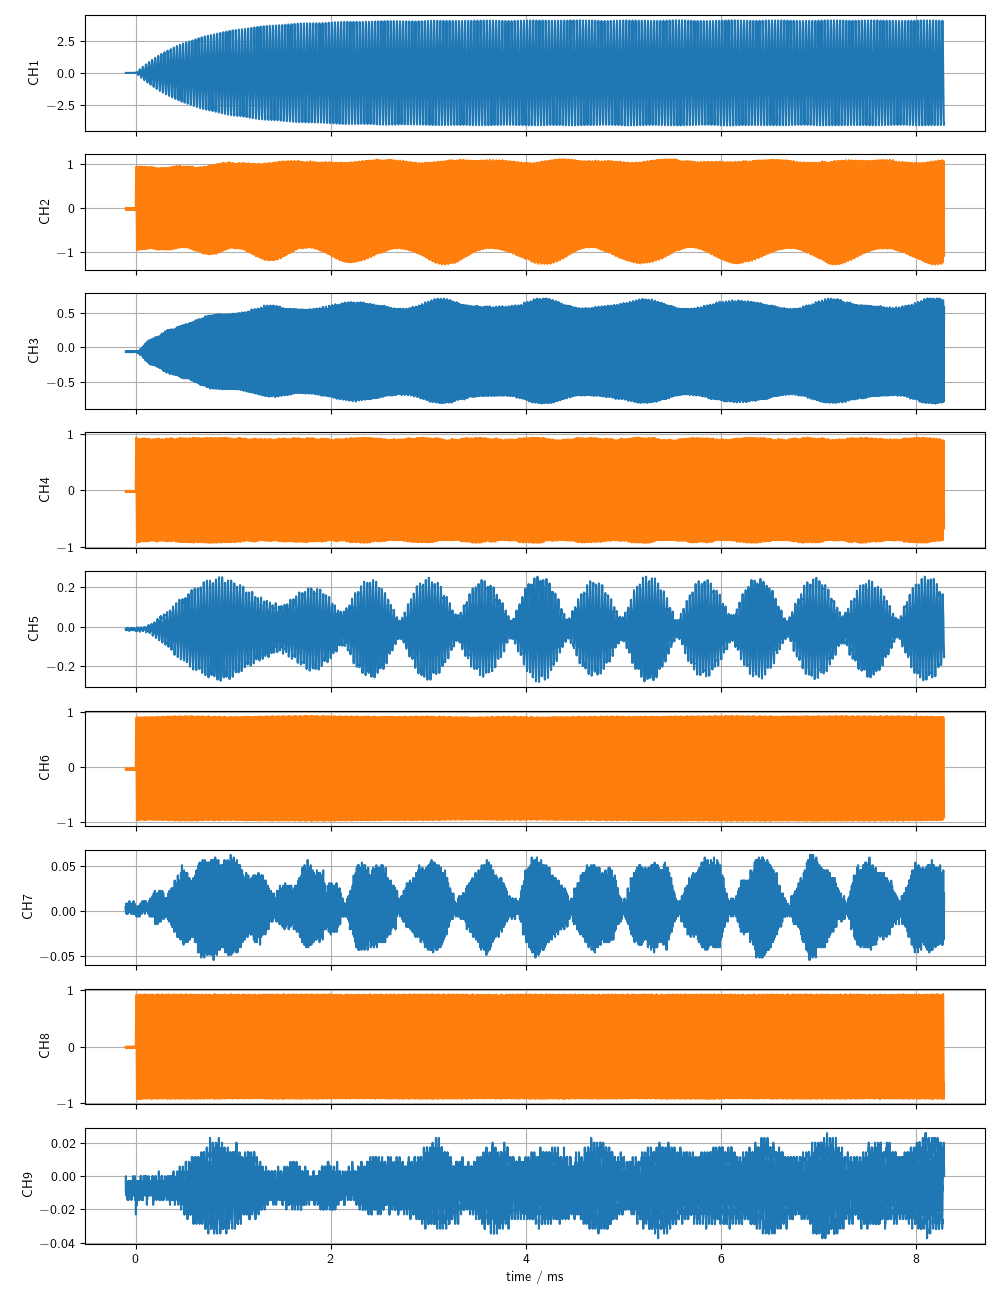

In [11]:
fdrv = lattice[0,:,1] - fs[0] + m1
ν = fdrv

# Index where driving on resonance
shotidx = 209

plot_traces(lattice, shotidx);

Extract frequency and amplitude from spectrum:
* use boxcar window to get frequency shifts,
* use flattop window to get amplitudes at those frequencies.

Main lobe attenuation of flattop window is -13.3 dB.  
http://www.marcuswinter.de/media/window%20functions%20cheat%20sheet.pdf  
Main lobe of boxcar window is at 0 dB.  
Attenuations are defined above in 'Shared code' section.

Discard first third of spectrum where dynamics is still relaxing.

In [12]:
# Spectrum for plotting
spectrum, fbins = time_spectrum(lattice[...,lattice.shape[-1]//3:], samplerate, window=windows.hann)
# Spectrum to find frequencies
spectrumf, fbins = time_spectrum(lattice[...,lattice.shape[-1]//3:], samplerate, window=windows.boxcar)
# Spectrum to get amplitudes
spectrumA, fbins = time_spectrum(lattice[...,lattice.shape[-1]//3:], samplerate, window=windows.flattop)

f bin size 0.17874302187242608 kHz


<IPython.core.display.Javascript object>


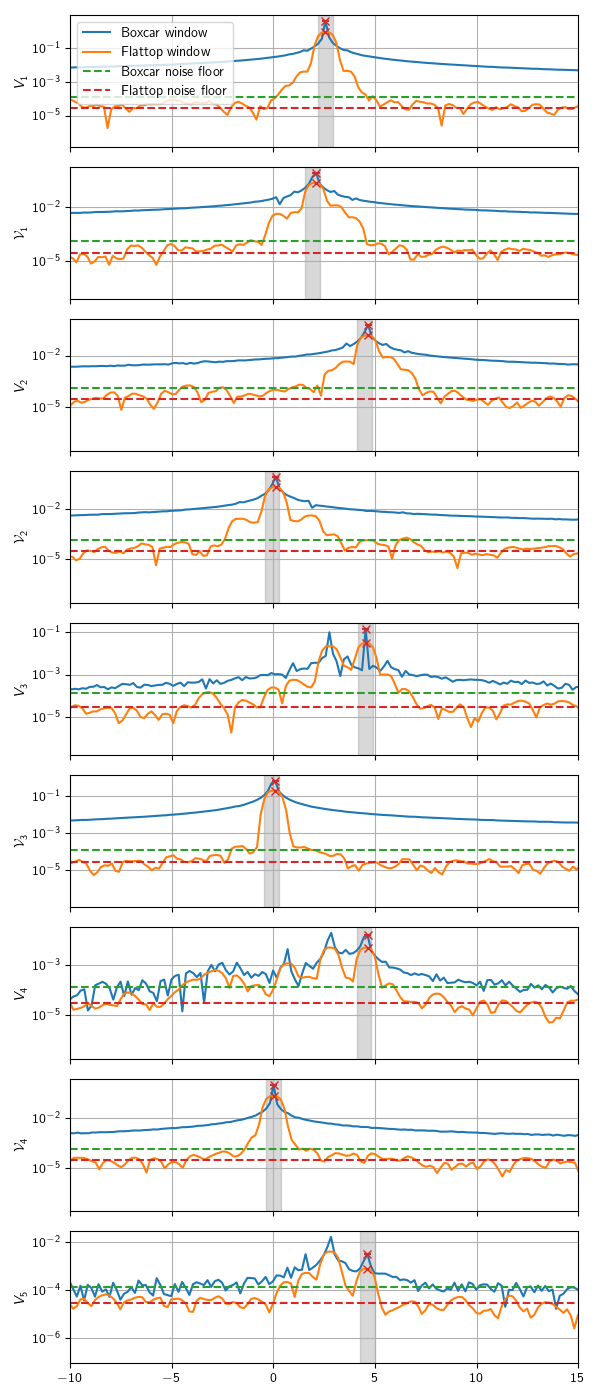

lidx 0 (1 ): peak 31.459 kHz (width 0.188 kHz), shift 0.058 kHz, amplitude 4105.79 mV
lidx 1 (1'): peak 62.024 kHz (width 0.255 kHz), shift 2.103 kHz, amplitude 1046.41 mV
lidx 2 (2 ): peak 93.483 kHz (width 0.205 kHz), shift 2.161 kHz, amplitude  674.45 mV
lidx 3 (2'): peak 60.236 kHz (width 0.201 kHz), shift 0.123 kHz, amplitude  906.76 mV
lidx 4 (3 ): peak 33.246 kHz (width 0.179 kHz), shift 2.038 kHz, amplitude  138.88 mV
lidx 5 (3'): peak 62.203 kHz (width 0.311 kHz), shift 0.091 kHz, amplitude  940.90 mV
lidx 6 (4 ): peak 95.449 kHz (width 0.348 kHz), shift 2.184 kHz, amplitude   22.84 mV
lidx 7 (4'): peak 60.951 kHz (width 0.186 kHz), shift 0.010 kHz, amplitude  912.74 mV
lidx 8 (5 ): peak 34.497 kHz (width 0.234 kHz), shift 2.028 kHz, amplitude    3.46 mV


In [13]:
from scipy.signal import find_peaks, peak_widths


# Noise of spectral components due to 5mV measurement noise
nums = lattice.shape[-1]//3
Vnoise = nums**0.5 * 0.005 / nums * 2

fbinsize = fbins[1]
print(f"f bin size {fbins[1]/1e3} kHz")

# Initial guess of shift to select peaks
fshiftexpect = 2.0e3 # Hz
fexpwindow = int(0.5e3 / fbinsize)

# Prepare arrays to save peak positions and heights
l = (spectrum.shape[0]+1)//2
fshift = np.full(l, np.nan)
fshifterr = fbinsize

height = np.full(l, np.nan)
linkheight = np.full(l-1, np.nan)
heighterr = Vnoise * FLATTOP_PEAKLOSS

fig, axs = plt.subplots(nrows=spectrum.shape[0], sharex=True, figsize=(6, 14))
Δ = calcΔ(calcδ(fs))
rf = calc_rfbase(fs)
for i in range(spectrum.shape[0]):
    axs[i].set_ylabel(fmt_title('V', i))
    axs[i].plot((fbins-rf[i])/1e3, spectrumf[i,shotidx], label="Boxcar window")
    axs[i].plot((fbins-rf[i])/1e3, spectrumA[i,shotidx], label="Flattop window")
    axs[i].axhline(Vnoise * BOXCAR_PEAKLOSS, color='C2', linestyle='--', label="Boxcar noise floor")
    axs[i].axhline(Vnoise * FLATTOP_PEAKLOSS, color='C3', linestyle='--', label="Flattop noise floor")
    
    if i == 0:
        fexp = m1
    elif i%2 == 0:
        fexp = Δ[i//2]/2 + fshiftexpect
    elif i == 1:
        fexp = fshiftexpect
    else:
        fexp = 0
    
    #axs[i].axvline(fexp/1e3, color='k', zorder=-1)
    centeridx = np.argmin(np.absolute(fbins - rf[i] - fexp))
    axs[i].axvspan(
        (fbins[centeridx-fexpwindow]-rf[i])/1e3,
        (fbins[centeridx+fexpwindow]-rf[i])/1e3,
        color='gray', alpha=0.3, zorder=-2)
    
    peaks = find_peaks(
        spectrumf[i, shotidx, centeridx-fexpwindow:centeridx+fexpwindow+1],
        distance=fexpwindow*3)
    width = peak_widths(spectrumf[i, shotidx, centeridx-fexpwindow:centeridx+fexpwindow+1], peaks[0])
    drvpeakidx = centeridx - fexpwindow + peaks[0][0]
    axs[i].errorbar(
        [(fbins[drvpeakidx]-rf[i])/1e3], [spectrumf[i, shotidx, drvpeakidx]],
        xerr=[fshifterr/1e3],
        fmt='x', color='C3')
    axs[i].errorbar(
        [(fbins[drvpeakidx]-rf[i])/1e3], [spectrumA[i, shotidx, drvpeakidx]],
        yerr=[heighterr],
        fmt='x', color='C3')
        
    if i%2 == 0:
        shift = fbins[drvpeakidx] - rf[i] - Δ[i//2]/2
        fshift[i//2] = shift
        height[i//2] = spectrumA[i, shotidx, drvpeakidx]
    else:
        shift = fbins[drvpeakidx] - rf[i]
        linkheight[i//2] = spectrumA[i, shotidx, drvpeakidx]

    print(f"lidx {i} ({i//2+1}"+("'" if i%2==1 else " ") +"): "
          f"peak {fbins[drvpeakidx]/1e3:.3f} kHz (width {width[0][0]*fbinsize/1e3:.3f} kHz), shift {shift/1e3:.3f} kHz, "
          f"amplitude {spectrumA[i, shotidx, drvpeakidx]/FLATTOP_PEAKLOSS*1e3:7.2f} mV")
    
    axs[i].grid()
    axs[i].set_yscale('log')
axs[0].legend(loc='upper left')
plt.xlim(-10, 15)
plt.tight_layout()

Calculate $J$ from frequency shift $f_U$ on second site (eq. F11).  
Calculate error from error on frequency shift $\Delta J = \frac{\partial J}{\partial f_U} \Delta f_U$:

In [14]:
νr = ν[shotidx]

As = height / FLATTOP_PEAKLOSS

Jexp = ((2*fshift[1] + m + νr)**2 - (m + νr)**2)**0.5 / (2 * As[0])
Jexperr = 1/(8*J*As[0]**2)* 4 * (2*fshift[1]+m+νr) * fshifterr
print(f"J = {Jexp/1e3:.4f} +- {Jexperr/1e3:.4f} kHz")

J = 0.9644 +- 0.0543 kHz


## Fig 7
Take a look at the amplitude decay along the lattice:

[-1.75412908  1.42817108]
[0.02889779 0.07078483]
[[ 0.00083508 -0.00167016]
 [-0.00167016  0.00501049]]
Base of decay ( A=b^(-d) ) b = 0.17305789599729152
Comparison:            BJ/2m = 0.17417999837499387


<IPython.core.display.Javascript object>


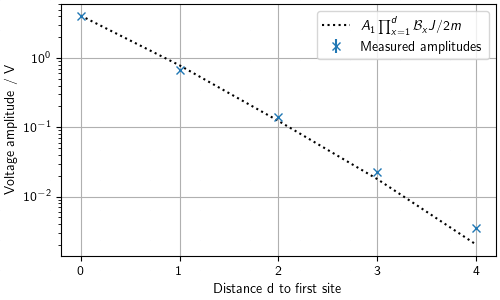

In [15]:
from scipy.optimize import curve_fit

d = np.arange(fshift.size)
ds = np.linspace(0, l-1, 100)

popta, pcova = curve_fit(lambda x, a, b: a * x + b, d, np.log(As))
perra = np.sqrt(np.diag(pcova))
print(popta)
print(perra)
print(pcova)

Bs = linkheight / FLATTOP_PEAKLOSS
print("Base of decay ( A=b^(-d) ) b =", np.exp(popta[0]))
print("Comparison:            BJ/2m =", np.mean(Bs) * J/(2*m))

plt.figure(figsize=(5,3), constrained_layout=True)
dsa = np.linspace(0, 4, 100)

Bprod = np.array([np.prod(Bs[:i]) for i in range(len(Bs)+1)])
plt.plot(d, (Bprod * J/m/2)**d * As[0], 'k:', label='$A_1 \prod_{x=1}^d \mathcal B_x J/2m$')
#plt.fill_between(d, (Bprod * (J-Jerr)/m/2)**d * As[0], (Bprod * (J+Jerr)/m/2)**d * As[0])
plt.errorbar(d, As, yerr=Vnoise, fmt='x', label="Measured amplitudes")
#plt.plot(d, Vrms[::2,shotidx] * 2**0.5, 'go', label="RMS")
#plt.axhline(Vnoise/FLATTOP_PEAKLOSS, color='C1', label='noise floor')

plt.grid()
plt.yscale('log')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("Distance d to first site")
plt.ylabel("Voltage amplitude / V")
plt.legend()

plt.savefig('/home/hannes/plot.pdf')

## Fig 4
Estimate amplitude of first site for all driving frequencies using RMS value:

In [16]:
# Use second half of trace only, to avoid initial relaxation.
Vrms = np.sqrt(np.mean(lattice[:,:,lattice.shape[-1]//2:]**2, axis=-1))

<IPython.core.display.Javascript object>


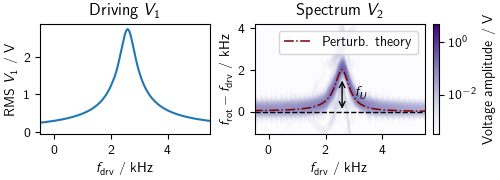

In [17]:
fig, (ax1, ax2) = fig.subplots = plt.subplots(
    ncols=2, sharex=True,
    figsize=(5, 1.8), constrained_layout=True)

Vrms1 = np.sqrt(np.mean(lattice[0,:,METALEN+INIT_SAMPLE:]**2, axis=1))
ax = ax1
ax.plot(fdrv/1e3, Vrms1)
ax.set_ylabel(r"RMS $V_1$ / V")
ax.set_xlabel(r"$f_\text{drv}$ / kHz")
ax.set_title(r"Driving "+fmt_title("V", 0))

from matplotlib.transforms import Affine2D
trafo = Affine2D(np.array([
    [ 1, 0, 0],
    [ -1, 1, 0],
    [ 0, 0, 1]
]))

lidx = 2
vmin, vmax = 3e-4, 5
ax = ax2
im = ax.imshow(
    spectrum[lidx].T, origin='lower',
    extent=(
        fdrv[0]/1e3, fdrv[-1]/1e3,
        (fbins[0]-rf[lidx])/1e3, (fbins[-1]-rf[lidx])/1e3),
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap='Purples', aspect='auto', interpolation='bicubic')
im.set_transform(trafo + ax.transData)

# PT prediction
A = Vrms[0] * 2**0.5
μ = np.sqrt((m+ν)**2 + (2*J*A)**2)/2
ax.plot(fdrv/1e3, ((μ-(m-ν)/2) - fdrv)/1e3, '-.', color='maroon', linewidth=1.1, label='Perturb. theory')

ax.axhline(0, color='k', linestyle='--', linewidth=1)
plt.annotate(text='', xy=(fdrv[shotidx]/1e3, 0.75*fshift[1]/1e3), xytext=(fdrv[shotidx]/1e3, 0), arrowprops=dict(arrowstyle='<->'))
plt.annotate(text=r"$f_U$", xy=(fdrv[shotidx]/1e3+0.5, fshift[1]/3/1e3))
ax.set_ylim(-1.1, 4.2)
ax.set_xlim(-0.5, 5.5)
ax.set_ylabel(r"$f_\text{rot} - f_\text{drv}$ / kHz")
ax.set_xlabel(r"$f_\text{drv}$ / kHz")
ax.set_title(r"Spectrum " + fmt_title("V", lidx))
ax.legend(loc='upper right')

cb = fig.colorbar(im)
cb.set_label('Voltage amplitude / V')
cb.minorticks_off()

plt.savefig('/home/hannes/plot.pdf')

Use amplitudes to calculate perturbative prediction for frequency shifts $f_U$ at $f_\text{drv}=+m$.  
Systematic error of $f_U$ calculated from systematic error on $J$, which means that it is exactly the frequency resolution for the $f_U$ of the second site, because this was used to get $J$.

In [18]:
νs = np.zeros(5)
νs[0] = νr

fUexp, fUexperr = np.zeros(5), np.zeros(5)
for i in range(1, 5):
    if i%2 == 0:  # odd site
        μi = np.sqrt((m-νs[i-1])**2 - (2*J*As[i-1])**2)/2
        μierr = 1/(8*μi) * 8 * As[i-1]**2 * J * Jerr
        νs[i] = μi + (m + νs[i-1])/2
        fUexp[i] = νs[i] - νr
        fUexperr[i] = μierr + fUexperr[i-1]
    else: # even site
        μi = np.sqrt((m+νs[i-1])**2 + (2*J*As[i-1])**2)/2
        μierr = 1/(8*μi) * 8 * As[i-1]**2 * J * Jerr
        νs[i] = μi - (m - νs[i-1])/2
        fUexp[i] = νs[i] - νr
        fUexperr[i] = μierr + fUexperr[i-1]

print(' ν ', νs/1e3, 'kHz')
print(' fU', fUexp/1e3, 'kHz')
print('ΔfU', fUexperr/1e3, 'kHz sys.')

 ν  [2.58219141 4.59064744 4.38492604 4.38729182 4.38705621] kHz
 fU [0.         2.00845604 1.80273464 1.80510041 1.8048648 ] kHz
ΔfU [0.         0.17019337 0.19531591 0.19557297 0.19559858] kHz sys.


<IPython.core.display.Javascript object>


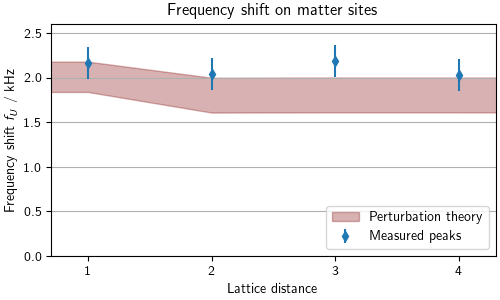

In [19]:
plt.figure(figsize=(5,3), constrained_layout=True)
ax = plt.gca()
ax.errorbar(
    d[1:], fshift[1:]/1e3, yerr=fshifterr/1e3, markersize=5,
    fmt='d', color='C0', label="Measured peaks", zorder=3)
ax.fill_between(
    [0.5, *d[1:], d[-1]+0.5], (fUexp[[1,1,2,3,4,4]]-fUexperr[[1,1,2,3,4,4]])/1e3, (fUexp[[1,1,2,3,4,4]]+fUexperr[[1,1,2,3,4,4]])/1e3,
    color='maroon', label="Perturbation theory", alpha=0.3, zorder=-1)
ax.set_ylim(0, 2.6)
ax.set_xlim(0.7, d[-1] + 0.3)
ax.grid(axis='y')
ax.legend(loc='lower right')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)
ax.set_ylabel(r"Frequency shift $f_U$ / kHz")
ax.set_xlabel("Lattice distance")
ax.set_title("Frequency shift on matter sites")

plt.savefig('/home/hannes/plot.pdf')

Δ [5.014 5.014 5.012 4.902 5.192] kHz
m average 2.5134000000000003 kHz


<IPython.core.display.Javascript object>


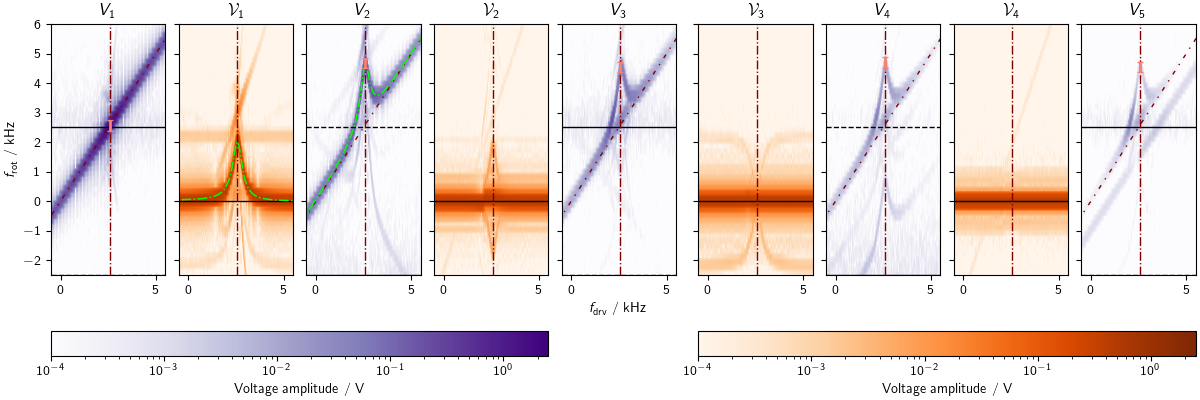

Driving freq. 31.476 kHz, in rotating frame 2.582 kHz
2.5821914060000015 kHz


In [20]:
fig, axs = plot_rotating_frame(
    spectrum, fbins, fs[:lattice.shape[0]],
    xs=fdrv/1e3, xlabel=r"$f_\text{drv}$ / kHz",
    fdrv=fdrv,
    frange=7e3, vmin=1e-4, vmax=2.5)
axs[0].set_xlim(-0.5, 5.5)
axs[0].set_ylim(-2.5, 6)
#axs[0].set_xlim(-7, 7)
#axs[0].set_ylim(-9, 9)
fig.set_size_inches(12, 4)

print(f"Driving freq. {lattice[0,shotidx,1]/1e3:.3f} kHz, in rotating frame {fdrv[shotidx]/1e3:.3f} kHz")
print(fdrv[shotidx]/1e3, "kHz")
for ax in axs:
    ax.axvline(fdrv[shotidx]/1e3, color='maroon', linestyle='-.', linewidth=1)

A = Vrms[0] * 2**0.5
μ = np.sqrt((m+ν)**2 + (2*J*A)**2)/2
axs[1].plot(fdrv/1e3, (μ-(ν+m)/2)/1e3, '-.', color='lime', linewidth=1.1)
axs[2].plot(fdrv/1e3, (μ-(m-ν)/2)/1e3, '-.', color='lime', linewidth=1.1)

for i in range(len(fshift)):
    axs[2*i].errorbar([fdrv[shotidx]/1e3], [(m+fshift[i])/1e3], yerr=[fshifterr/1e3], fmt=' ', color='salmon', linewidth=2, zorder=5, capsize=2)

## Fig 8

Δ [5.014 5.014 5.012 4.902 5.192] kHz
m average 2.5134000000000003 kHz


<IPython.core.display.Javascript object>


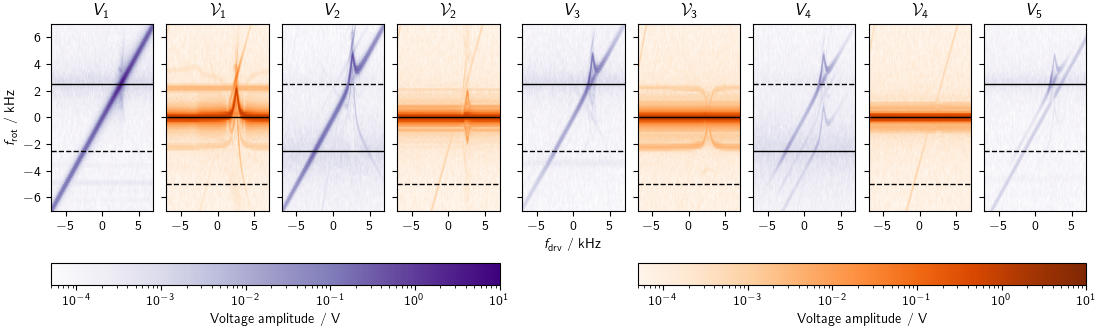

In [21]:
fig, axs = plot_rotating_frame(
    spectrum / HANN_PEAKLOSS, fbins, fs[:lattice.shape[0]],
    xs=fdrv/1e3, xlabel=r"$f_\text{drv}$ / kHz",
    frange=7e3, vmin=5e-5, vmax=1e1)
axs[0].set_xlim(-7, 7)
axs[0].set_ylim(-7, 7)
fig.set_size_inches(11, 3.3)

plt.savefig('/home/hannes/plot.pdf')

#for ax in axs:
#    ax.axvline(fdrv[shotidx]/1e3, color='maroon', linestyle='-.', linewidth=1)

# Spectrum, Fig 2B
Dataset 2021-04-30 set 1

In [22]:
Vdrv = 0.0
data1 = load_chain(f'04-30/set1a/CH1-V1_CH2-Vsense_CH3-V2_CH4-V3_Vdrv={Vdrv:.3f}V.gz')
data2 = load_chain(f'04-30/set1a/CH1-V1_CH2-V1link_CH3-V4_CH4-V5_Vdrv={Vdrv:.3f}V.gz')
data3 = load_chain(f'04-30/set1a/CH1-V1_CH2-V2link_CH3-V3link_CH4-V4link_Vdrv={Vdrv:.3f}V.gz')
samplerate = data1[0,0,0]

mux = [(0, 0), (1, 1), (0, 2), (2, 1), (0, 3), (2, 2), (1, 2), (2, 3), (1, 3)]
lattice = mux_lattice([data1, data2, data3], mux)
del data1, data2, data3

# free resonance frequencies and oscillator amplitudes
fs = [30.710e3, 59.705e3, 85.424e3, 59.570e3, 30.868e3, 61.683e3, 87.560e3, 60.479e3, 32.139e3]

print('δ', calcδ(fs)/1e3, 'kHz')
print('Δ', calcΔ(calcδ(fs))/1e3, 'kHz')

δ [4.991 5.014 4.991 5.058] kHz
Δ [4.991 4.991 5.037 4.945 5.171] kHz


In [23]:
spectrum, fbins = time_spectrum(lattice[...,METALEN+INIT_SAMPLE:], samplerate, window=windows.hann)

<IPython.core.display.Javascript object>


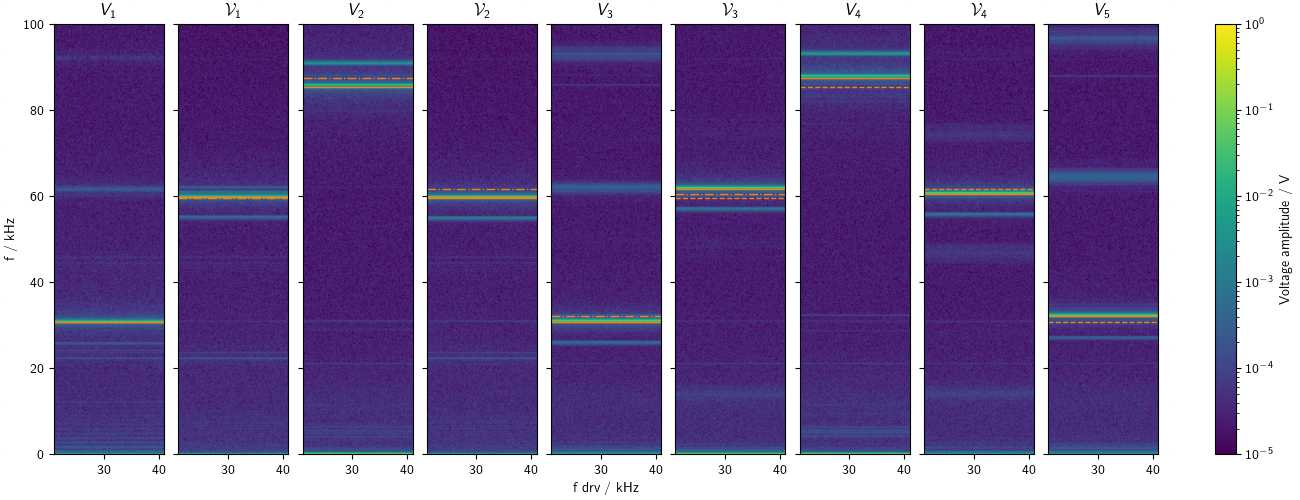

(0.0, 100.0)

In [24]:
fig, axs = plot_spectrum(spectrum, fbins, lattice[0,:,1]/1e3, fs)
axs[0].set_ylim(0, 100)

Δ [4.991 4.991 5.037 4.945 5.171] kHz
m average 2.5135 kHz


<IPython.core.display.Javascript object>


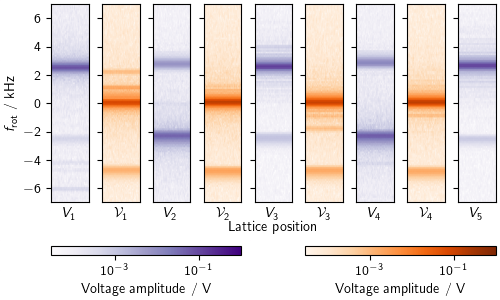

In [25]:
fdrv = lattice[0,:,1] - fs[0] + calcΔ(calcδ(fs))[0] / 2
fig, axs = plot_rotating_frame(
    spectrum / HANN_PEAKLOSS, fbins, fs[:lattice.shape[0]],
    xs=fdrv/1e3, xlabel='f drv / kHz', #fdrv=fdrv,# idxs=[4,5,6],
    frange=10e3, vmin=3e-5, vmax=1, freelines=False,
    subplots_kw={'gridspec_kw': {'bottom': 0.5}});
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.xticks([])
for i in range(len(fs)):
    axs[i].set_xlabel(fmt_title("V", i))
    axs[i].set_title(None)
axs[len(fs)//2].set_xlabel(fmt_title("V", len(fs)//2)+'\\\\\n Lattice position')
fig.set_size_inches(5, 3)
fig.set_constrained_layout_pads(h_pad=0.01, w_pad=0.01, hspace=0, wspace=0)
plt.savefig('/home/hannes/plot.pdf')

# Mass Dependence

In [27]:
# Correction for current driver on first site.
# Use for data sets before 19 April 2021.
DRVCORR = -0.3e3 # Hz

sets = [
    (0e3, '01-25/set1/',
     np.array([31.065e3+DRVCORR, 54.045e3, 85.050e3, 54.267e3, 30.777e3, 55.935e3, 86.704e3, 54.676e3, 32.028e3]),
     np.array([0.80, 0.83, 0.94, 0.90, 0.78, 0.59, 0.87, 0.75, 0.81])),
    (1e3, '02-15/set2/',
     np.array([31.1019e3+DRVCORR, 55.0432e3, 85.1811e3, 55.2851e3, 30.8388e3, 57.1358e3, 86.9935e3, 56.0075e3, 32.0641e3]),
     np.array([0.96, 0.94, 0.91, 0.92, 0.90, 0.92, 0.93, 0.93, 0.90])),
    (2e3, '02-09/set1/',
     np.array([31.0884e3+DRVCORR, 55.9038e3, 85.0288e3, 56.2390e3, 30.8159e3, 57.7898e3, 86.6525e3, 56.6088e3, 32.0383e3]),
     np.array([0.88, 0.93, 0.93, 0.90, 0.89, 0.92, 0.87, 0.92, 0.88])),
    (3e3, '05-03/set2/',
     np.array([31.110e3, 57.103e3, 84.840e3, 57.338e3, 30.871e3, 59.427e3, 86.794e3, 58.142e3, 32.169e3]),
     None),
    #(3e3, '02-11/set1/',
    # np.array([31.0826e3+DRVCORR, 56.9611e3, 85.0393e3, 57.2707e3, 30.8235e3, 58.9180e3, 86.6150e3, 57.5943e3, 32.0402e3]),
    # np.array([0.91, 0.92, 0.94, 0.90, 0.87, 0.91, 0.95, 0.93, 0.90])),
    (4e3, '02-05/set1/',
     np.array([31.0615e3+DRVCORR, 58.0423e3, 85.1232e3, 58.3726e3, 30.7999e3, 59.8302e3, 86.6096e3, 58.6034e3, 32.0085e3]),
     np.array([0.89, 0.93, 0.91, 0.92, 0.94, 0.94, 0.94, 0.94, 0.92])),
    (5e3, '03-10/set1a/',
     np.array([31.0672e3+DRVCORR, 59.1050e3, 85.1864e3, 59.3431e3, 30.8503e3, 61.2390e3, 87.0928e3, 60.0200e3, 32.0740e3]),
     np.array([0.95, 0.92, 0.96, 0.93, 0.90, 0.92, 0.91, 0.95, 0.90])),
     #np.array([30.7046e3, 59.4125e3, 85.0814e3, 59.2406e3, 30.8216e3, 61.1939e3, 87.0366e3, 59.9845e3, 32.0720e3]),
     #np.array([0.91, 0.95, 0.92, 0.94, 0.88, 0.94, 0.91, 0.94, 0.90])),
    (6e3, '02-11/set2/',
     np.array([31.0903e3+DRVCORR, 59.9660e3, 85.0551e3, 60.2152e3, 30.8216e3, 61.7336e3, 86.6042e3, 60.4945e3, 32.0641e3]),
     np.array([0.92, 0.92, 0.93, 0.92, 0.87, 0.94, 0.96, 0.92, 0.90])),
    (7e3, '03-05/set1a/',
     np.array([31.0576e3+DRVCORR, 61.0465e3, 85.1601e3, 61.2617e3, 30.8426e3, 63.2381e3, 87.0605e3, 61.9425e3, 32.0621e3]),
     np.array([0.95, 0.94, 0.96, 0.93, 0.90, 0.92, 0.92, 0.94, 0.90])),
    (8e3, '02-04/set1/',
     np.array([31.063e3+DRVCORR, 62.017e3, 85.076e3, 62.267e3, 30.808e3, 63.760e3, 86.572e3, 62.583e3, 32.016e3]),
     np.array([0.91, 0.93, 0.92, 0.94, 0.93, 0.93, 0.95, 0.90, 0.91]))
]

mux = [(0, 0), (1, 1), (0, 2), (2, 1), (0, 3), (2, 2), (1, 2), (2, 3), (1, 3)]

Vdrv = 0
samplerate = 1953125.0
allffts = []
for Δ, prefix, fres, Vosc in sets:
    print(f"Loading Δ={Δ/1e3:.2f}kHz ...")
    data1 = load_chain(prefix+f'CH1-V1_CH2-Vsense_CH3-V2_CH4-V3_Vdrv={Vdrv:.3f}V.gz')
    data2 = load_chain(prefix+f'CH1-V1_CH2-V1link_CH3-V4_CH4-V5_Vdrv={Vdrv:.3f}V.gz')
    data3 = load_chain(prefix+f'CH1-V1_CH2-V2link_CH3-V3link_CH4-V4link_Vdrv={Vdrv:.3f}V.gz')
    assert np.all(data1[:,:0] == samplerate)
    assert np.all(data2[:,:0] == samplerate)
    assert np.all(data3[:,:0] == samplerate)
    
    lattice = mux_lattice([data1, data2, data3], mux)
    del data1, data2, data3
    
    ffts, fftbins = time_spectrum(lattice[...,METALEN+INIT_SAMPLE:], samplerate, window=windows.hann)
    allffts.append(np.mean(ffts, axis=1))
    del lattice
ffts = np.array(allffts)

Loading Δ=0.00kHz ...
Loading Δ=1.00kHz ...
Loading Δ=2.00kHz ...
Loading Δ=3.00kHz ...
Loading Δ=4.00kHz ...
Loading Δ=5.00kHz ...
Loading Δ=6.00kHz ...
Loading Δ=7.00kHz ...
Loading Δ=8.00kHz ...


## Fig 7

<IPython.core.display.Javascript object>


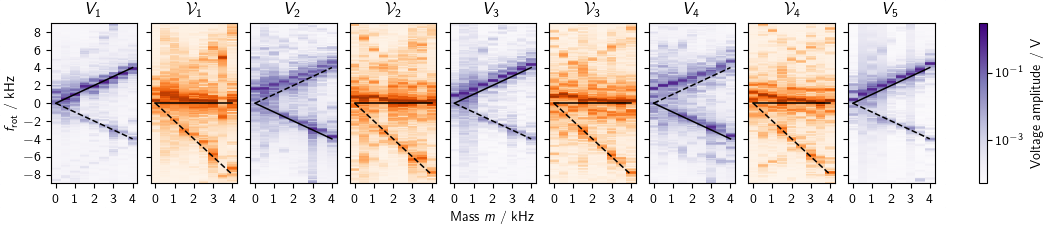

## Δ = 0.0 kHz
mean Δ = -50.4 kHz
Δ range -500.0 to 500.0
## Δ = 1.0 kHz
mean Δ = 941.2 kHz
Δ range 500.0 to 1500.0
## Δ = 2.0 kHz
mean Δ = 1941.0 kHz
Δ range 1500.0 to 2500.0
## Δ = 3.0 kHz
mean Δ = 3429.0 kHz
Δ range 2500.0 to 3500.0
## Δ = 4.0 kHz
mean Δ = 3956.8 kHz
Δ range 3500.0 to 4500.0
## Δ = 5.0 kHz
mean Δ = 4940.4 kHz
Δ range 4500.0 to 5500.0
## Δ = 6.0 kHz
mean Δ = 5914.7 kHz
Δ range 5500.0 to 6500.0
## Δ = 7.0 kHz
mean Δ = 6884.1 kHz
Δ range 6500.0 to 7500.0
## Δ = 8.0 kHz
mean Δ = 7951.2 kHz
Δ range 7500.0 to 8500.0


In [28]:
vmin, vmax = 5e-5, 3e0
idxs = list(range(ffts.shape[1]))

fig, axs = plt.subplots(ncols=len(idxs), figsize=(10.5, 2.3),
                        sharex=True, sharey=True, constrained_layout=True)

Ω = 0.014 * 60e3
xlo, xhi = None, None
for j in range(len(sets)):
    Δ, prefix, fres, Vosc = sets[j]
    if j == 0:
        ΔΔlo = ΔΔhi = (sets[1][0] - Δ)/2
        xlo = Δ - ΔΔlo
    elif j == len(sets)-1:
        ΔΔlo = ΔΔhi = (Δ - sets[-2][0])/2
        xhi = Δ + ΔΔhi
    else:
        ΔΔlo = (Δ - sets[j-1][0])/2
        ΔΔhi = (sets[j+1][0] - Δ)/2
    
    Δs = calcΔ(calcδ(fres))
    Δmean = np.mean(Δs)
    print(f"## Δ = {Δ/1e3:.1f} kHz")
    print(f"mean Δ = {Δmean:.1f} kHz")
    print(f"Δ range", Δ-ΔΔlo, "to", Δ+ΔΔhi)
    
    rf = calc_rfbase(fres)
    for i, idx in enumerate(idxs):
        cmap = 'Purples' if idx%2 == 0 else 'Oranges'
        dat = np.tile(ffts[j][idx], (2,1))
        im = axs[i].imshow(
            dat.T / HANN_PEAKLOSS, origin='lower',
            extent=(
                (Δ-ΔΔlo)/2/1e3, (Δ+ΔΔhi)/2/1e3,
                (fftbins[0]-rf[idx])/1e3,
                (fftbins[-1]-rf[idx])/1e3),
            norm=LogNorm(vmin=vmin, vmax=vmax),
            cmap=cmap, aspect='auto', interpolation='nearest')

color1, color2 = 'black', 'black'
lwidth = 1.1
for i, idx in enumerate(idxs):
    if idx % 2 == 0:
        if i//2 % 2 == 0: # odd site
            axs[i].plot([0, 8/2], [0, 4], linestyle='-', color=color1, linewidth=lwidth)
            axs[i].plot([0, 8/2], [0, -4], linestyle='--', color=color1, linewidth=lwidth)
        else: # even site
            axs[i].plot([0, 8/2], [0, 4], linestyle='--', color=color1, linewidth=lwidth)
            axs[i].plot([0, 8/2], [0, -4], linestyle='-', color=color1, linewidth=lwidth)
    else: # link
        axs[i].plot([0, 8/2], [0, 0], linestyle='-', color=color2, linewidth=lwidth)
        axs[i].plot([0, 8/2], [0, -8], linestyle='--', color=color2, linewidth=lwidth)
    axs[i].set_title(fmt_title("V", idx)) # fontsize=9)

axs[0].set_ylim(-9, +9)
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].set_ylabel(r"$f_\text{rot}$ / kHz")
axs[0].set_xticks([0, 1, 2, 3, 4])
axs[0].set_xlim(xlo/2/1e3, xhi/2/1e3)
axs[len(idxs)//2].set_xlabel(r"Mass $m$ / kHz")

cb = fig.colorbar(im, ax=axs)
cb.set_label('Voltage amplitude / V')
cb.minorticks_off()

#axs[0].set_title("odd sites")
#axs[1].set_title("links")
#axs[2].set_title("even sites")

plt.savefig('/home/hannes/plot.pdf')

## Fig 3

<IPython.core.display.Javascript object>


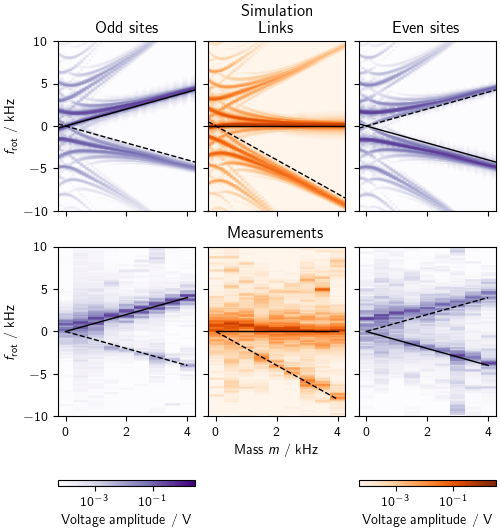

Δ = 0.0 kHz: -500.0 to 500.0 Hz
Δ = 1.0 kHz: 500.0 to 1500.0 Hz
Δ = 2.0 kHz: 1500.0 to 2500.0 Hz
Δ = 3.0 kHz: 2500.0 to 3500.0 Hz
Δ = 4.0 kHz: 3500.0 to 4500.0 Hz
Δ = 5.0 kHz: 4500.0 to 5500.0 Hz
Δ = 6.0 kHz: 5500.0 to 6500.0 Hz
Δ = 7.0 kHz: 6500.0 to 7500.0 Hz
Δ = 8.0 kHz: 7500.0 to 8500.0 Hz


In [29]:
vmin, vmax = 5e-5, 3e0
color1, color2 = 'black', 'black'
lwidth = 1

# `ffts` has the shape (#sets, #resonators, #fbins)

_, rfbins, _ = shift_to_rotating_frame(ffts[0], fftbins, sets[0][2], fwidth=20e3)
rfspectrum = np.array([
    shift_to_rotating_frame(ffts[j], fftbins, sets[j][2], fwidth=20e3)[0]
        for j in range(len(sets))])
rfodd = np.mean(rfspectrum[:, ::4], axis=1)
rfeven = np.mean(rfspectrum[:, 2::4], axis=1)
rflink = np.mean(rfspectrum[:, 1::2], axis=1)

simdeltas = np.load('detuning_ms.npy')*2
simfbins = np.load('detuning_fbins.npy')
simys = np.load('detuning_fftys.npy')
simodd = np.mean(np.absolute(simys[..., ::4]), axis=-1)
simeven = np.mean(np.absolute(simys[..., 2::4]), axis=-1)
simlink = np.mean(np.absolute(simys[..., 1::2]), axis=-1)

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(5, 5.3),
                        sharex=True, sharey=True, constrained_layout=True)
xlo, xhi = None, None
for j in range(len(sets)):
    Δ, prefix, fres, Vosc = sets[j]
    if j == 0:
        ΔΔlo = ΔΔhi = (sets[1][0] - Δ)/2
        xlo = Δ - ΔΔlo
    elif j == len(sets)-1:
        ΔΔlo = ΔΔhi = (Δ - sets[-2][0])/2
        xhi = Δ + ΔΔhi
    else:
        ΔΔlo = (Δ - sets[j-1][0])/2
        ΔΔhi = (sets[j+1][0] - Δ)/2
    
    Δs = calcΔ(calcδ(fres))
    print(f"Δ = {Δ/1e3:.1f} kHz: {Δ-ΔΔlo} to {Δ+ΔΔhi} Hz")
    
    im = axs[1,0].imshow(
        np.tile(rfodd[j], (2,1)).T, origin='lower',
        extent=(
            (Δ-ΔΔlo)/2/1e3, (Δ+ΔΔhi)/2/1e3,
            rfbins[0]/1e3, rfbins[-1]/1e3),
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap='Purples', aspect='auto', interpolation='nearest')
    im = axs[1,1].imshow(
        np.tile(rflink[j], (2,1)).T, origin='lower',
        extent=(
            (Δ-ΔΔlo)/2/1e3, (Δ+ΔΔhi)/2/1e3,
            rfbins[0]/1e3, rfbins[-1]/1e3),
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap='Oranges', aspect='auto', interpolation='nearest')
    im = axs[1,2].imshow(
        np.tile(rfeven[j], (2,1)).T, origin='lower',
        extent=(
            (Δ-ΔΔlo)/2/1e3, (Δ+ΔΔhi)/2/1e3,
            rfbins[0]/1e3, rfbins[-1]/1e3),
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap='Purples', aspect='auto', interpolation='nearest')

axs[1,0].plot([0, 8/2], [0, 4], linestyle='-', color=color1, linewidth=lwidth)
axs[1,0].plot([0, 8/2], [0, -4], linestyle='--', color=color1, linewidth=lwidth)
axs[1,1].plot([0, 8/2], [0, 0], linestyle='-', color=color2, linewidth=lwidth)
axs[1,1].plot([0, 8/2], [0, -8], linestyle='--', color=color2, linewidth=lwidth)
axs[1,2].plot([0, 8/2], [0, 4], linestyle='--', color=color1, linewidth=lwidth)
axs[1,2].plot([0, 8/2], [0, -4], linestyle='-', color=color1, linewidth=lwidth)


im1 = axs[0,0].imshow(
    simodd.T, origin='lower',
    extent=(simdeltas[0]/2, simdeltas[-1]/2, simfbins[0], simfbins[-1]),
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap='Purples', aspect='auto')#, interpolation='nearest')
im2 = axs[0,1].imshow(
    simlink.T, origin='lower',
    extent=(simdeltas[0]/2, simdeltas[-1]/2, simfbins[0], simfbins[-1]),
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap='Oranges', aspect='auto')#, interpolation='nearest')
im1 = axs[0,2].imshow(
    simeven.T, origin='lower',
    extent=(simdeltas[0]/2, simdeltas[-1]/2, simfbins[0], simfbins[-1]),
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap='Purples', aspect='auto')#, interpolation='nearest')

axs[0,0].plot(simdeltas/2, simdeltas/2, linestyle='-', color=color1, linewidth=lwidth)
axs[0,0].plot(simdeltas/2, -simdeltas/2, linestyle='--', color=color2, linewidth=lwidth)
axs[0,1].plot(simdeltas/2, np.zeros(simdeltas.shape), linestyle='-', color=color1, linewidth=lwidth)
axs[0,1].plot(simdeltas/2, -simdeltas, linestyle='--', color=color2, linewidth=lwidth)
axs[0,2].plot(simdeltas/2, simdeltas/2, linestyle='--', color=color1, linewidth=lwidth)
axs[0,2].plot(simdeltas/2, -simdeltas/2, linestyle='-', color=color2, linewidth=lwidth)

axs[0,0].set_ylim(-10, +10)
#axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[0,0].set_ylabel(r"$f_\text{rot}$ / kHz")
axs[1,0].set_ylabel(r"$f_\text{rot}$ / kHz")
#axs[0].set_xticks([0, 2, 4, 6, 8])
axs[0,0].set_xlim(xlo/2/1e3, xhi/2/1e3)
axs[1,1].set_xlabel(r"Mass $m$ / kHz")

cb = fig.colorbar(im1, ax=axs[:,0], shrink=1, orientation='horizontal')
cb.set_label("Voltage amplitude / V")
#cb.minorticks_off()
cb = fig.colorbar(im2, ax=axs[:,2], shrink=1, orientation='horizontal').set_label("Voltage amplitude / V")

axs[0,0].set_title("Odd sites")
axs[0,1].set_title("Simulation\\\\\nLinks")
axs[0,2].set_title("Even sites")
axs[1,1].set_title("Measurements")

plt.savefig('/home/hannes/plot.pdf')

# Conservation
Dateset 2021-05-21 set 2

In [31]:
Vdrv = 0.0
lattice = load_chain(f'05-21/set2_CH1-site1_CH2-link1_CH3-site2_CH4-link2_CH5-site3_CH6-link3_CH7-site4_CH8-link4_CH9-site5_CH10-empty.gz')
lattice = lattice[:-1]
samplerate = lattice[0,0,0]

# free resonance frequencies and oscillator amplitudes
fs = [31.104e3, 55.590e3, 84.850e3, 56.137e3, 30.886e3, 58.120e3, 86.802e3, 57.309e3, 32.124e3]

print('δ', calcδ(fs)/1e3, 'kHz')
print('Δ', calcΔ(calcδ(fs))/1e3, 'kHz')

δ [1.844 2.173 2.204 2.631] kHz
Δ [1.844 1.844 2.502 1.906 3.356] kHz


In [32]:
print('m', calcΔ(calcδ(fs))/2/1e3, 'kHz')

m [0.922 0.922 1.251 0.953 1.678] kHz


Δ [1.844 1.844 2.502 1.906 3.356] kHz
m average 1.1452 kHz


<IPython.core.display.Javascript object>


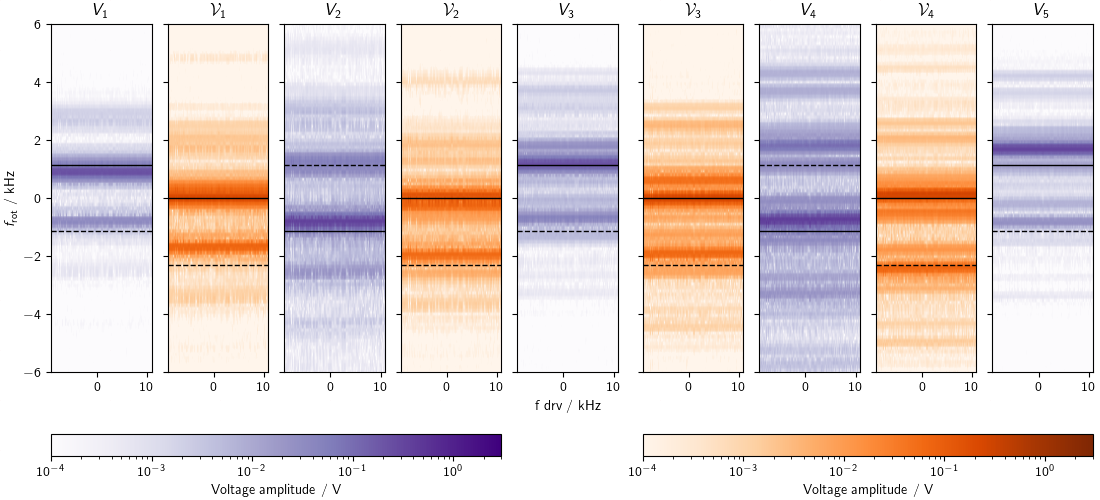

In [33]:
spectrum, fbins = time_spectrum(lattice[...,METALEN+INIT_SAMPLE:], samplerate, window=windows.hann)

fdrv = lattice[0,:,1] - fs[0] + calcΔ(calcδ(fs))[0] / 2
fig, axs = plot_rotating_frame(
    spectrum, fbins, fs[:lattice.shape[0]],
    xs=fdrv/1e3, xlabel='f drv / kHz', #fdrv=fdrv,# idxs=[4,5,6],
    frange=6e3, vmin=1e-4, vmax=3)
#plt.xlim(-7, 7)
#plt.ylim(-7, 7)

plt.savefig('/home/hannes/plot.png')

In [34]:
from scipy.signal import savgol_filter, find_peaks
from scipy.interpolate import InterpolatedUnivariateSpline as Spline1D


def slice_compose(*slices):
    """Compose multiple nested slices along a same axis into one slice."""
    assert all(s.stop >= 0 for s in slices)
    return slice(
        sum(s.start for s in slices),
        slices[-1].stop + sum(s.start for s in slices[:-1]))

def slice_intersect(slices, data=None):
    """Calculate intersection of slices.
    Optionally return data inside intersection (first axis) of every slice."""
    # Assertion not necessary. Might be interesting to use in cases
    # where this assertion is not true ;)
    # assert all(s.step is None or s.step == 1 for s in slices)
    
    inters = slice(
        max(s.start for s in slices),
        min(s.stop for s in slices))
    assert inters.start <= inters.stop, "No intersection."
    
    if data:
        interd = [
            trace[inters.start-s.start:inters.stop-s.start,...]
            for s, trace in zip(slices, data)
        ]
        return inters, interd
    else:
        return inters


def envelope_spline(signal, samplerate, fexp, t0sample=INIT_SAMPLE,
                    start_thresh=0.2, peak_height=0.02, quiet=False):
    """Optionally smooth signal, get peaks, optionally smooth peaks, make spline for envelope.
    
    Returns: tuple of
      time for each sample in seconds, 0s at trigger,
      spline object based on time in seconds,
      slice for time where spline is valid,
      rms difference between consecutive voltage samples.
    """
    ts = (np.arange(signal.shape[0]) - t0sample) / samplerate
    
    # First smoothing: signal
    beginidx = np.argmax(signal > start_thresh)
    smoothwin = int(samplerate/fexp / 10)
    smoothwin -= 1 if smoothwin % 2 == 0 else 0
    if smoothwin > 3:
        if not quiet: print(f"  Signal: smoothing window: {smoothwin} samples")
        smoothed = savgol_filter(signal[beginidx:], window_length=smoothwin, polyorder=3)
    else:
        if not quiet: print(f"  Signal: no smoothing, window {smoothwin} samples !> 3")
        smoothed = signal[beginidx:]
    
    # Find peaks and fit spline (envelope).
    # Note that indexing for these arrays is offset by `beginidx`.
    peakidxs = find_peaks(smoothed, height=peak_height, distance=0.75*samplerate/fexp)[0]
    
    favg = (peakidxs.size-1) / (ts[beginidx+peakidxs[-1]] - ts[beginidx+peakidxs[0]])
    t_jitter = np.std(np.diff(ts[beginidx+peakidxs]))
    V_jitter = np.sqrt(np.mean((np.diff(smoothed[peakidxs]))**2))
    if not quiet:
        print(f"  Avg peak frequency: {favg/1e3:.3f} kHz")
        print(f"  Jitter of peak positions: {t_jitter*1e6:.5f} us ({1e-6/t_jitter:.2f} MHz)")
        print(f"  Jitter of peak heights:   {V_jitter:.4f} V")
    
    spline = Spline1D(ts[beginidx:][peakidxs], signal[beginidx:][peakidxs], k=3)
    srange = slice(beginidx+peakidxs[0], beginidx+peakidxs[-1])
    
    return ts, spline, srange, V_jitter


def topbot(ts, signal, distance):
    """Use peaks to get top and bottom range of signal, interpolated linearly between peaks."""
    samplerate = 1 / (ts[1] - ts[0])
    peakidxs = find_peaks(signal, distance=distance)[0]
    troughidxs = find_peaks(-signal, distance=distance)[0]
    srange = slice(max(np.min(peakidxs), np.min(troughidxs)),
                   min(np.max(peakidxs), np.max(troughidxs)))
    top = np.interp(ts[srange], ts[peakidxs], signal[peakidxs])
    bot = np.interp(ts[srange], ts[troughidxs], signal[troughidxs])
    return srange, top, bot


def energy(V, Verr, C=20e-9):
    """Energy stored in capacitor at given Voltage.  Returns E, Eerr."""
    return (
        C/2 * V**2,
        C * V * Verr
    )

# Assumes site 1, link 1, site 2, link 2, ... along first axis
def Gx(Es, Eerr, fs, f0=60e3):
    Eerr = np.broadcast_to(Eerr, Es.shape)
    l = (Es.shape[0]+1)//2
    Gs, Gerr = [], []
    Gtot, Gtoterr2 = 0, 0
    for i in range(l):
        x = i + 1 # x starting from 1
        
        G = Es[2*i] * f0/fs[2*i]
        Gerr2 = (Eerr[2*i] * f0/fs[2*i])**2
        if 2*i > 0:
            G += (-1)**x * Es[2*i-1] * f0/fs[2*i-1]
            Gerr2 += (Eerr[2*i-1] * f0/fs[2*i-1])**2
        if 2*i < Es.shape[0]-1:
            G += (-1)**x * Es[2*i+1] * f0/fs[2*i+1]
            Gerr2 += (Eerr[2*i+1] * f0/fs[2*i+1])**2
        Gs.append(G), Gerr.append(np.sqrt(Gerr2))
        
        Gtot += Es[2*i] * f0/fs[2*i]
        Gtoterr2 += (Eerr[2*i] * f0/fs[2*i])**2

    return np.array(Gs), np.array(Gerr), Gtot, np.sqrt(Gtoterr2)


# Like G but averages over contributions for G instead of calculating G.
# Assumes site 1, link 1, site 2, link 2, ... along first axis
def Gxavg(Es, Eerr, fs, f0=60e3):
    Eerr = np.broadcast_to(Eerr, Es.shape)
    l = (Es.shape[0]+1)//2
    Gs, Gerr = [], []
    Gtot, Gtoterr2 = 0, 0
    for i in range(l):
        N = 1
        G = Es[2*i] * f0/fs[2*i]
        Gerr2 = (Eerr[2*i] * f0/fs[2*i])**2
        if 2*i > 0:
            G += Es[2*i-1] * f0/fs[2*i-1]
            Gerr2 += (Eerr[2*i-1] * f0/fs[2*i-1])**2
            N += 1
        if 2*i < Es.shape[0]-1:
            G += Es[2*i+1] * f0/fs[2*i+1]
            Gerr2 += (Eerr[2*i+1] * f0/fs[2*i+1])**2
            N += 1
        Gs.append(G/N), Gerr.append(np.sqrt(Gerr2/N))
        
        Gtot += Es[2*i] * f0/fs[2*i] / l
        Gtoterr2 += (Eerr[2*i] * f0/fs[2*i] / l)**2

    return np.array(Gs), np.array(Gerr), Gtot, np.sqrt(Gtoterr2)

## Data
Load data such that `lattice`, `samplerate`, and `fs` is set.

Δ [1.844 1.844 2.502 1.906 3.356] kHz
m average 1.1452 kHz


<IPython.core.display.Javascript object>


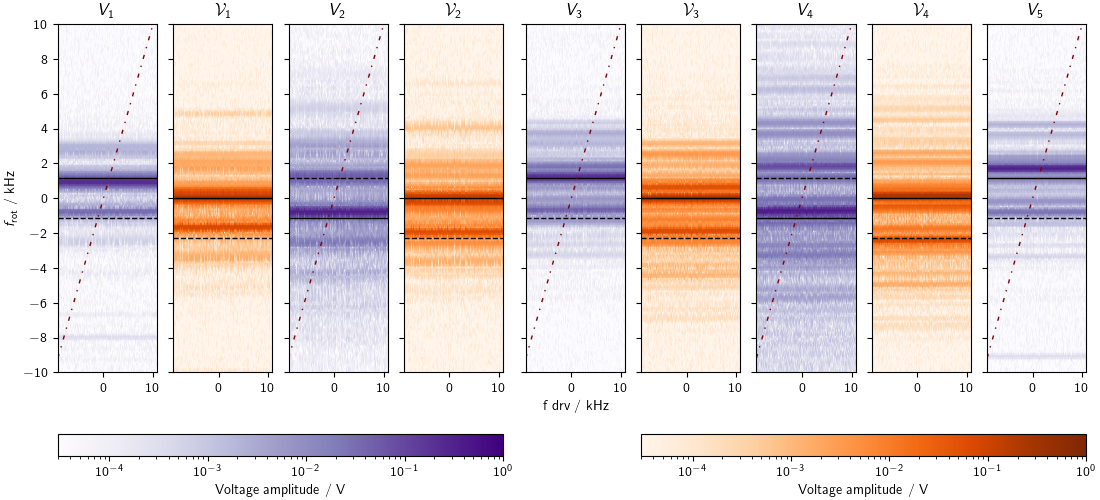

In [35]:
ffts, fftbins = time_spectrum(lattice[...,METALEN+INIT_SAMPLE:], samplerate, window=windows.hann)

fdrv = lattice[0,:,1] - fs[0] + calcΔ(calcδ(fs))[0] / 2
plot_rotating_frame(
    ffts, fftbins, fs,
    xs=fdrv/1e3, xlabel='f drv / kHz',
    fdrv=fdrv, #fdrvcorr=fcorrs,
    frange=10e3, vmin=3e-5, vmax=1);
#plt.savefig('/home/hannes/plot.png', dpi=500)

## Filter
Remove data before init and do one of these

  * Remove offset only or
  * Bandpass filter around rotating frame or
  * Low pass filter above rotating frame.

<IPython.core.display.Javascript object>


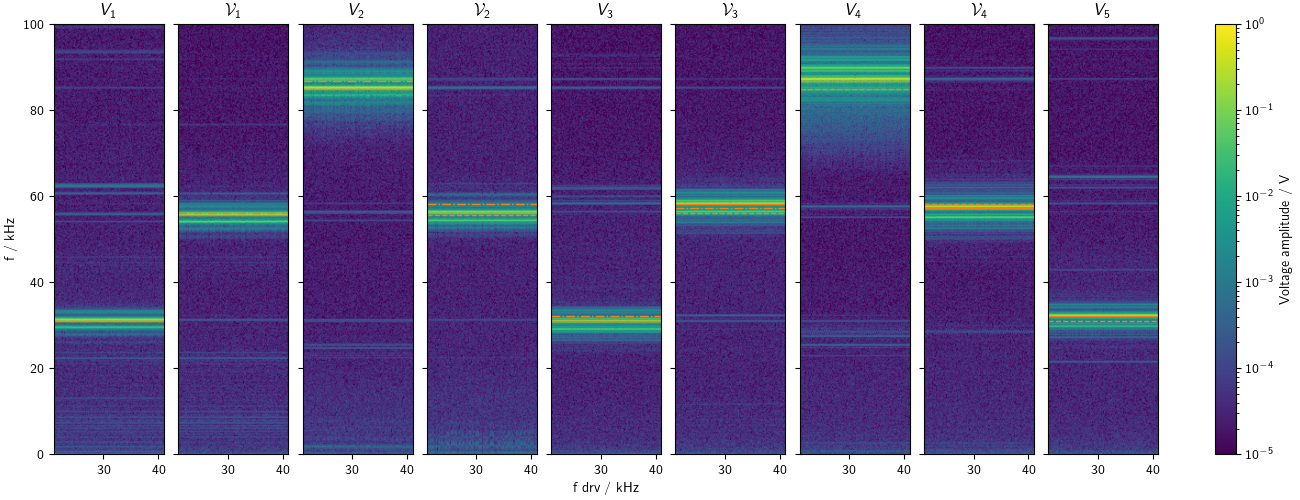

In [36]:
FILTER = 'offset' # offset / bandpass / lowpass
FWIDTH = 20e3

# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='low')
    return b, a


filtered = lattice[...,METALEN+INIT_SAMPLE:].copy()
for i, f in enumerate(fs):
    if FILTER == 'offset':
        filtered[i] -= np.mean(filtered[i], axis=-1)[...,np.newaxis]
    elif FILTER == 'bandpass':
        filtered[i] = lfilter(*butter_bandpass(f-FWIDTH/2, f+FWIDTH/2, samplerate), filtered[i])
    elif FILTER == 'lowpass':
        filtered[i] = lfilter(*butter_lowpass(f+FWIDTH/2, samplerate), filtered[i])


spectrum, fbins = time_spectrum(filtered, samplerate, window=windows.hann)
fig, axs = plot_spectrum(spectrum, fbins, lattice[i,:,1]/1e3, fs)
axs[0].set_ylim(0, 100);

## Envelope

  * Select one of the time traces (`IDX`), then
  * fit peaks and get envelope.

[1.953125e+06 2.100000e+04 0.000000e+00 0.000000e+00 0.000000e+00
 1.000000e+00]
CH1 31.10kHz  $V_1$ 
  Signal: smoothing window: 5 samples
  Avg peak frequency: 31.071 kHz
  Jitter of peak positions: 0.83830 us (1.19 MHz)
  Jitter of peak heights:   0.0237 V
CH2 55.59kHz  $\mathcal{V}_1$ 
  Signal: no smoothing, window 3 samples !> 3
  Avg peak frequency: 55.590 kHz
  Jitter of peak positions: 0.34565 us (2.89 MHz)
  Jitter of peak heights:   0.0238 V
CH3 84.85kHz  $V_2$ 
  Signal: no smoothing, window 1 samples !> 3
  Avg peak frequency: 84.987 kHz
  Jitter of peak positions: 0.26036 us (3.84 MHz)
  Jitter of peak heights:   0.0214 V
CH4 56.14kHz  $\mathcal{V}_2$ 
  Signal: no smoothing, window 3 samples !> 3
  Avg peak frequency: 55.947 kHz
  Jitter of peak positions: 0.55200 us (1.81 MHz)
  Jitter of peak heights:   0.0203 V
CH5 30.89kHz  $V_3$ 
  Signal: smoothing window: 5 samples
  Avg peak frequency: 30.818 kHz
  Jitter of peak positions: 0.86025 us (1.16 MHz)
  Jitter of peak 

<IPython.core.display.Javascript object>


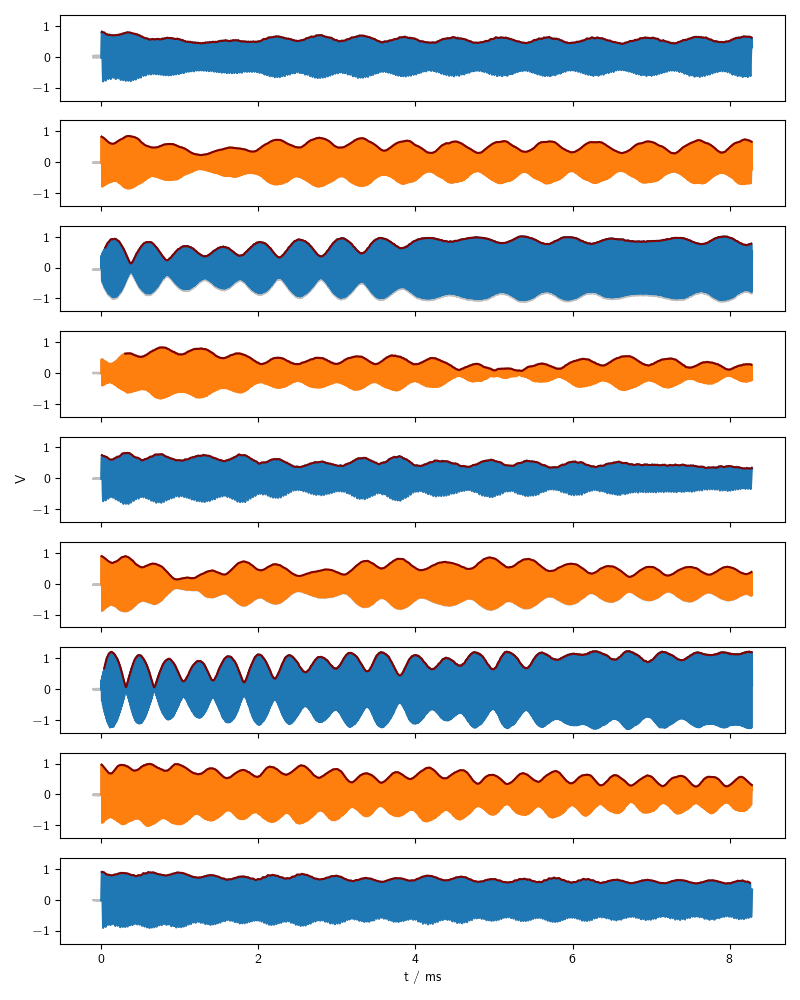

In [37]:
IDX = 0 # !!!
print(lattice[0,IDX,:6])

n = filtered.shape[0]

# Envelopes
ts, splines, tslices, Vjitters = None, [], [], []
for j in range(n):
    print(f"CH{j+1} {fs[j]/1e3:.2f}kHz {fmt_title('V', j)}")
    ts, spline, tslice, Vjitter = envelope_spline(
        filtered[j, IDX], samplerate, fs[j],
        t0sample=0, start_thresh=0.6, peak_height=0)
    splines.append(spline), tslices.append(tslice), Vjitters.append(Vjitter)
Vjitters = np.array(Vjitters)

tslattice = (np.arange(lattice.shape[-1]-METALEN) - INIT_SAMPLE) / samplerate
fig, axs = plt.subplots(nrows=filtered.shape[0], figsize=(8,10), sharex=True, sharey=True)
for i in range(n):
    axs[i].plot(tslattice*1e3, lattice[i, IDX, METALEN:], color='silver')#, alpha=0.2)
    axs[i].plot(ts*1e3, filtered[i, IDX], color='C%d'%(i%2))
    axs[i].plot(ts[tslices[i]]*1e3, splines[i](ts[tslices[i]]), color='maroon')
axs[len(axs)//2].set_ylabel('V')
axs[-1].set_xlabel('t / ms')
fig.tight_layout()

## Energies & background

  * Calculate energies from voltages and
  * remove background exponential.

V1l  a = 3.40 ± 0.01 nJ, b = 0.018 ± 0.001 ms
V1   a = 3.09 ± 0.03 nJ, b = 0.008 ± 0.002 ms
V2l  a = 3.85 ± 0.03 nJ, b = -0.108 ± 0.001 ms
V2   a = 5.48 ± 0.03 nJ, b = 0.325 ± 0.003 ms
V3l  a = 5.12 ± 0.02 nJ, b = 0.157 ± 0.001 ms
V3   a = 2.94 ± 0.03 nJ, b = 0.011 ± 0.002 ms
V4l  a = 5.15 ± 0.04 nJ, b = -0.121 ± 0.001 ms
V4   a = 8.02 ± 0.04 nJ, b = 0.177 ± 0.001 ms
V5l  a = 6.87 ± 0.01 nJ, b = 0.096 ± 0.001 ms


<IPython.core.display.Javascript object>


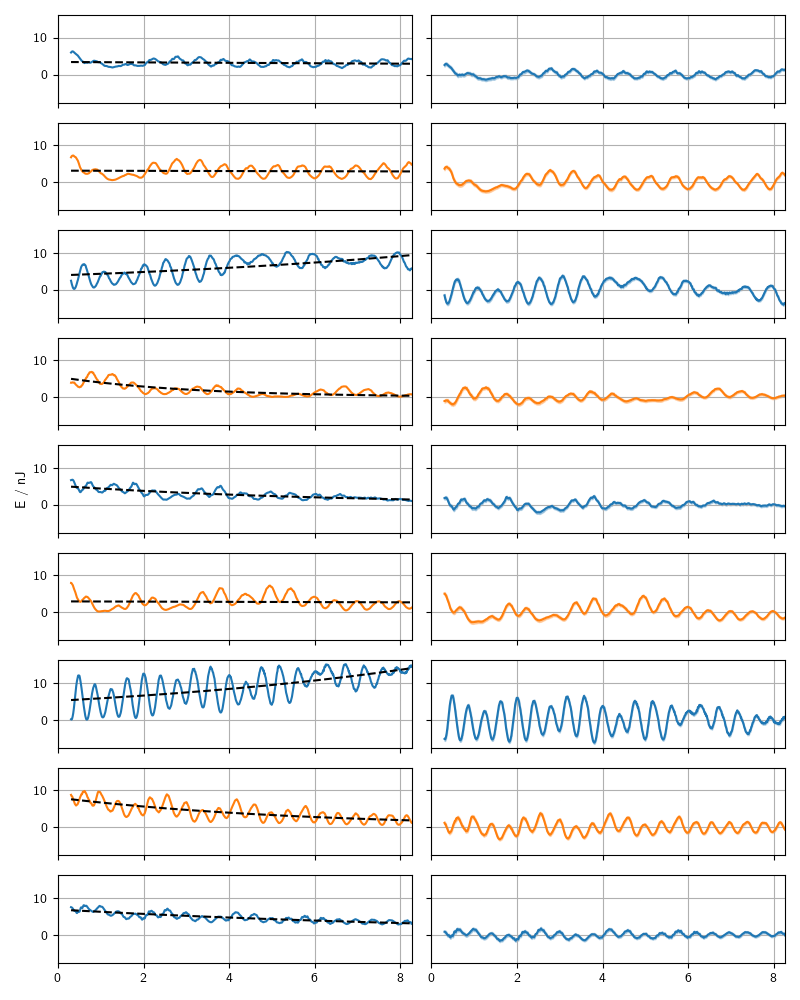

In [38]:
# fraction of data to take into account
FITEND = 8/8


from scipy.optimize import curve_fit


# Energies and 'charges' alingned to slice intersection
tslice = slice_intersect(tslices)
tslice = slice(tslice.start, min(tslice.stop, int(len(ts)*FITEND)))
tsbeat = ts[tslice]

Vs = np.array([spline(ts[tslice]) for spline in splines])
Es, Eerr = energy(Vs, Vjitters[:,np.newaxis])

def expbackground(t, a, b):
    return a * np.exp(-b * t)

fitend = int(len(ts)*FITEND)
bkgopt = [] # nJ, ms
bkgerr = [] # nJ, ms
Ebeat = [] # J
for i in range(n):
    popt, pcov = curve_fit(expbackground, tsbeat*1e3, Es[i]*1e9)
    perr = np.sqrt(np.diag(pcov))
    bkgopt.append(popt)
    bkgerr.append(perr)
    print(f"V{i//2+1}{'l' if i%2 == 0 else ' '}  "
          f"a = {popt[0]:.2f} ± {perr[0]:.2f} nJ, "
          f"b = {popt[1]:.3f} ± {perr[1]:.3f} ms")
    Ebeat.append(Es[i]-expbackground(tsbeat*1e3, *popt)*1e-9)
Ebeat = np.array(Ebeat)
Ebeaterr = Eerr[i]

fig, axs = plt.subplots(nrows=filtered.shape[0], ncols=2, sharex=True, sharey=True, figsize=(8, 10))
for i in range(n):
    axs[i,0].plot(ts[tslice]*1e3, Es[i]*1e9, color='C%d'%(i%2))
    axs[i,0].plot(tsbeat*1e3, expbackground(tsbeat*1e3, *bkgopt[i]), 'k--')
    axs[i,0].grid()
    
    axs[i,1].plot(tsbeat*1e3, Ebeat[i]*1e9, color='C%d'%(i%2))
    axs[i,1].fill_between(tsbeat*1e3, Ebeat[i]*1e9-Ebeaterr*1e9, Ebeat[i]*1e9+Ebeaterr*1e9, color='C%d'%(i%2), alpha=0.3)
    axs[i,1].grid()
axs[len(axs)//2,0].set_ylabel("E / nJ")
axs[0,0].set_xlim(0, tsbeat[-1]*1e3)
fig.tight_layout()

## Gauss laws & summary plot

<IPython.core.display.Javascript object>


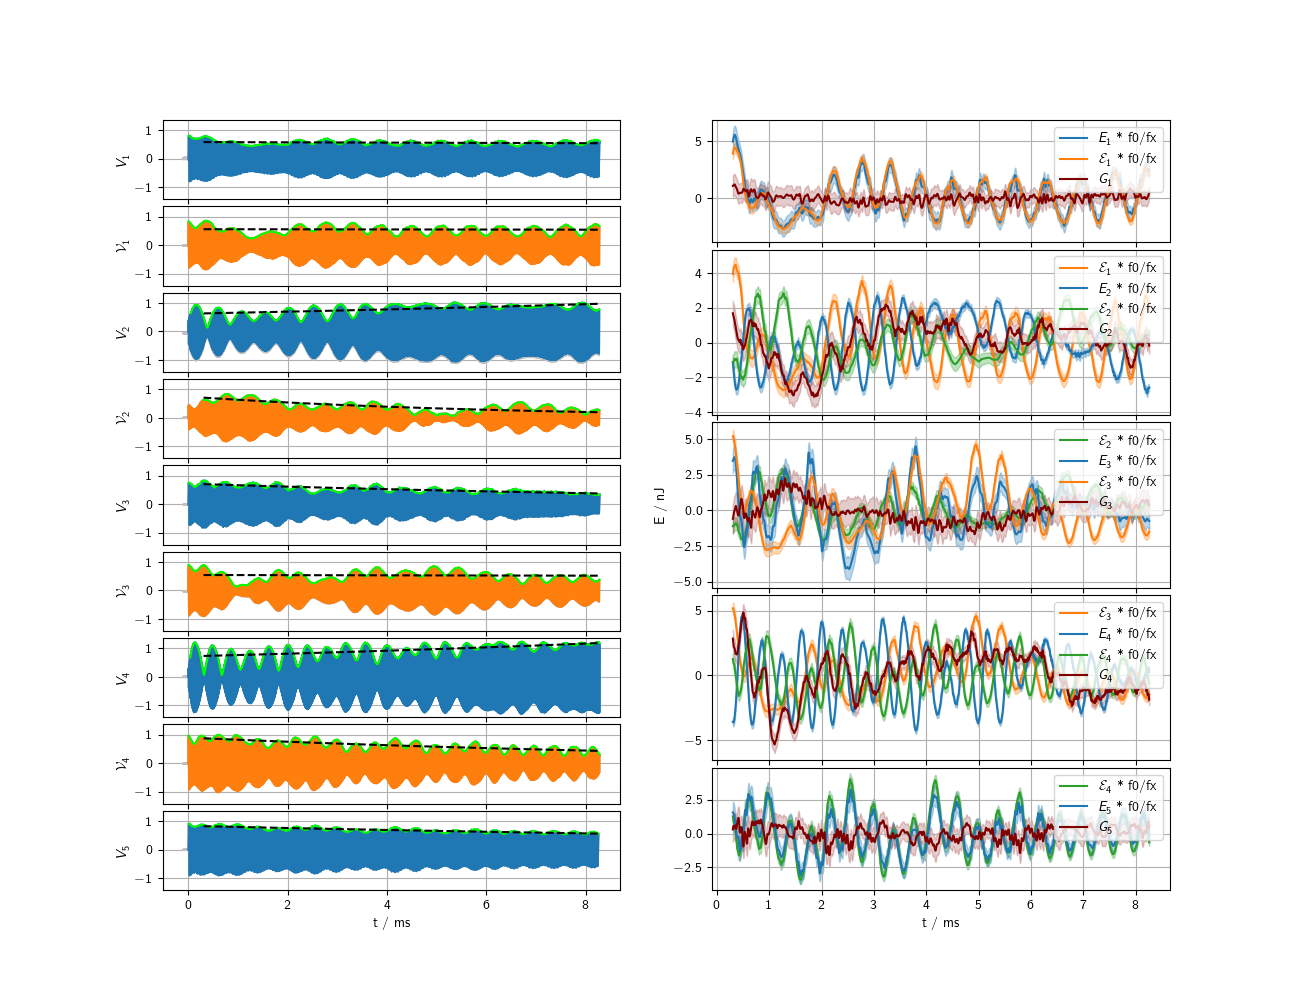

/tmp/ipykernel_165269/629626360.py:40: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('/home/hannes/plot.png')


In [39]:
from matplotlib.gridspec import GridSpec

Gs, Gerr, Gtot, Gtoterr = Gx(Ebeat, Ebeaterr, fs)
Etot = np.sum(Ebeat, axis=0)

fig = plt.figure(figsize=(13,10), constrained_layout=True)
gs = GridSpec(nrows=2*n, ncols=2, figure=fig)

naxs = [fig.add_subplot(gs[0:2,0])]
naxs += [fig.add_subplot(gs[2*i:2*i+2,0], sharex=naxs[0], sharey=naxs[0])
        for i in range(1, n)]
for i in range(n):
    naxs[i].plot(tslattice[:INIT_SAMPLE+tslices[i].stop]*1e3, lattice[i, IDX, METALEN:METALEN+INIT_SAMPLE+tslices[i].stop], color='silver')
    naxs[i].plot(ts[:tslices[i].stop]*1e3, filtered[i, IDX, :tslices[i].stop], color='C%d'%(i%2))
    naxs[i].plot(ts[tslices[i]]*1e3, splines[i](ts[tslices[i]]), color='lime')
    naxs[i].plot(tsbeat*1e3, np.sqrt(expbackground(tsbeat*1e3, *bkgopt[i])*1e-9/20e-9*2), 'k--')
    naxs[i].set_ylabel(fmt_title("V", i))
    naxs[i].grid()
    if i < n-2:
        pass #naxs[i].set_xticklabels([])
naxs[-1].set_xlabel('t / ms')

Gaxs = [fig.add_subplot(gs[max(4*i-1, 0):min(4*i+3, 2*n), 1])
        for i in range(len(Gs))]
for i, ax in enumerate(Gaxs):
    for j in range(max(i*2-1, 0), min(i*2+1+1, n)):
        scale = 60e3 / fs[j]
        color = 'C0' if j%2 == 0 else ('C1' if (j-1)%4 == 0 else 'C2')
        ax.plot(tsbeat*1e3, Ebeat[j]*scale*1e9, color=color, label=fmt_title("E", j, post=" * f0/fx"))
        ax.fill_between(tsbeat*1e3, (Ebeat[j]-Ebeaterr)*scale*1e9, (Ebeat[j]+Ebeaterr)*scale*1e9,
                        color=color, alpha=0.3)
    
    ax.plot(tsbeat*1e3, Gs[i]*1e9, color='maroon', label="$G_%d$"%(i+1))
    ax.fill_between(tsbeat*1e3, (Gs[i]-Gerr[i])*1e9, (Gs[i]+Gerr[i])*1e9, color='maroon', alpha=0.2)
    ax.grid()
    ax.legend(loc='upper right')
Gaxs[len(Gaxs)//2].set_ylabel("E / nJ")
Gaxs[-1].set_xlabel("t / ms")

plt.savefig('/home/hannes/plot.png')

<IPython.core.display.Javascript object>


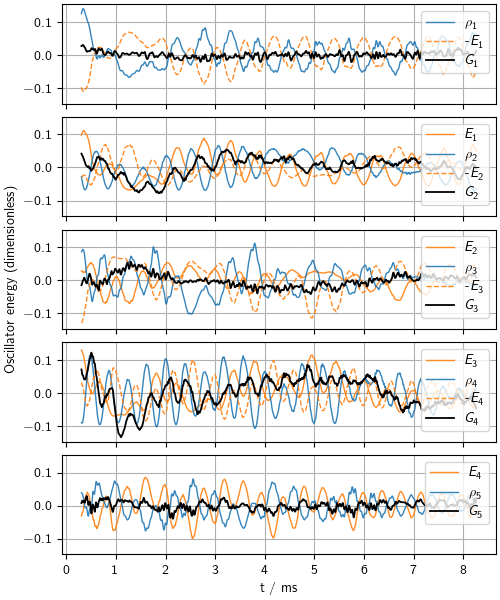

In [40]:
# Signs and offsets for 05-27 set1

f0 = 60e3
E0 = 2 * 20e-9 * 1**2

#signs = [
#    [1, -1],
#    [-1, 1, 1],
#    [1, 1, -1],
#    [-1, 1, 1],
#    [1, 1]
#]

signs = [
    # [E_x-1, ρ_x, E_x]
    [    1, -1],
    [+1, 1, -1],
    [+1, 1, -1],
    [+1, 1, -1],
    [+1, 1]
]

offsets = [
    [       +0.07, -0.07],
    [+0.14, +0.07, -0.07],
    [+0.14, +0.07, -0.07],
    [+0.14, +0.07, -0.07],
    [+0.14, +0.07]
]

fig, Gaxs = plt.subplots(nrows=len(Gs), figsize=(5, 6), constrained_layout=True, sharex=True, sharey=True)
for i, ax in enumerate(Gaxs):
    for j in range(max(i*2-1, 0), min(i*2+1+1, n)):
        nocc = Ebeat[j] / E0 * f0 / fs[j] * (-1 if (j-3)%4 == 0 else 1)
        color = 'C0' if j%2 == 0 else 'C1' #('C1' if (j-1)%4 == 0 else 'C3')
        if j%2 == 0:
            label = ("-" if signs[i][j-max(i*2-1, 0)] < 0 else "") + r"$\rho_%d$"%(j//2+1)
            lstyle= '-'
            lwidth = 1
        else:
            label = ("-" if signs[i][j-max(i*2-1, 0)] < 0 else "") + r"$E_%d$"%(j//2+1)
            if j < 2*i:
                lstyle = '-' # (0, (5, 1)) # ':'
            else:
                lstyle = '--'
            lwidth = 1
        offs = 0.7 
        ax.plot(tsbeat*1e3, signs[i][j-max(i*2-1, 0)]*nocc+0*offsets[i][j-max(i*2-1, 0)],
                color=color, label=label, alpha=0.9, linewidth=lwidth, linestyle=lstyle)
    
    ax.plot(tsbeat*1e3, Gs[i]/E0, color='k', label="$G_%d$"%(i+1), linewidth=1.3)
    ax.grid()
    ax.legend(loc='upper right')
Gaxs[len(Gaxs)//2].set_ylabel("Oscillator energy (dimensionless)")
Gaxs[-1].set_xlabel("t / ms")

#Gaxs[0].set_ylim(-0.2, 0.2)

plt.savefig('/home/hannes/plot.pdf')

<IPython.core.display.Javascript object>


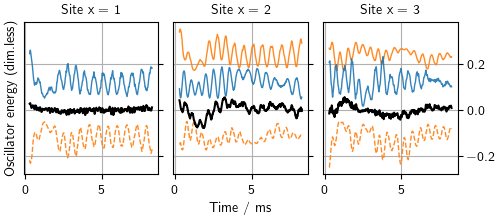

In [41]:
fig, Gaxs = plt.subplots(ncols=3, figsize=(5, 2.2), constrained_layout=True, sharex=True, sharey=True)
for i, ax in enumerate(Gaxs):
    for j in range(max(i*2-1, 0), min(i*2+1+1, n)):
        nocc = Ebeat[j] / E0 * f0 / fs[j] * (-1 if (j-3)%4 == 0 else 1)
        color = 'C0' if j%2 == 0 else 'C1' #('C1' if (j-1)%4 == 0 else 'C3')
        if j%2 == 0:
            label = ("-" if signs[i][j-max(i*2-1, 0)] < 0 else "") + r"$\rho_%d$"%(j//2+1)
            lstyle= '-'
            lwidth = 1
        else:
            label = ("-" if signs[i][j-max(i*2-1, 0)] < 0 else "") + r"$E_%d$"%(j//2+1)
            if j < 2*i:
                lstyle = '-'
            else:
                lstyle = '--'
            lwidth = 1
        ax.plot(tsbeat*1e3, signs[i][j-max(i*2-1, 0)]*nocc+0.12/0.07*offsets[i][j-max(i*2-1, 0)],
                color=color, label=label, alpha=0.9, linewidth=lwidth, linestyle=lstyle)
    
    ax.plot(tsbeat*1e3, Gs[i]/E0, color='k', label="$G_%d$"%(i+1))#, linewidth=1.3)
    ax.grid()
    #ax.legend(loc='upper right', ncol=2, handlelength=1.5, handletextpad=0.5, columnspacing=1.5)

#Gaxs[0].set_ylim(-0.2, 0.2)
Gaxs[0].set_ylabel("Oscillator energy (dim.less)")
Gaxs[1].set_xlabel("Time / ms")

for i in range(3):
    Gaxs[i].tick_params(axis='y', which='both', labelleft=False, labelright=False, left=False, right=True)
Gaxs[-1].tick_params(axis='y', which='both', labelright=True)

Gaxs[0].set_title("Site x = 1", fontsize=10)
Gaxs[1].set_title("Site x = 2", fontsize=10)
Gaxs[2].set_title("Site x = 3", fontsize=10)

plt.savefig('/home/hannes/plot.pdf')